In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
import umap
import joblib
import json
import os
import cv2
from tensorflow.keras.models import load_model
import ipywidgets as widgets
from IPython.display import display
from itertools import cycle, islice

In [ ]:
def extract_characters_from_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area < 100:
            continue
        aspect_ratio = w / h
        if aspect_ratio < 0.2 or aspect_ratio > 2.5:
            continue
        boxes.append((x, y, w, h))

    boxes = sorted(boxes, key=lambda b: (b[1] // 30, b[0]))

    chars = []
    for x, y, w, h in boxes:
        char = thresh[y:y+h, x:x+w]
        canvas = np.zeros((28, 28), dtype=np.uint8)
        char = cv2.resize(char, (min(w, 20), min(h, 20)))
        cx, cy = char.shape[1] // 2, char.shape[0] // 2
        x_offset = (28 // 2) - cx
        y_offset = (28 // 2) - cy
        canvas[y_offset:y_offset+char.shape[0], x_offset:x_offset+char.shape[1]] = char
        chars.append(canvas)

    return chars

def extract_characters_from_folder(folder_path):
    all_chars = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            chars = extract_characters_from_image(image_path)
            all_chars.extend(chars)

    return all_chars

carpeta = "Imagenes_Pares"
chars = extract_characters_from_folder(carpeta)
X = np.array([char.flatten().astype("float32") / 255.0 for char in chars])

In [3]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(500, activation='relu')(input_img)
encoded = layers.Dense(500, activation='relu')(encoded)
encoded = layers.Dense(2000, activation='relu')(encoded)
encoded = layers.Dense(64, activation=None)(encoded)

decoded = layers.Dense(2000, activation='relu')(encoded)
decoded = layers.Dense(500, activation='relu')(decoded)
decoded = layers.Dense(500, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

In [10]:
autoencoder.fit(X, X, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0124
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0123
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0113
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0111
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0108
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0107
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0103
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0101
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0094
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0090
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0088
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0087
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0085
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0090
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


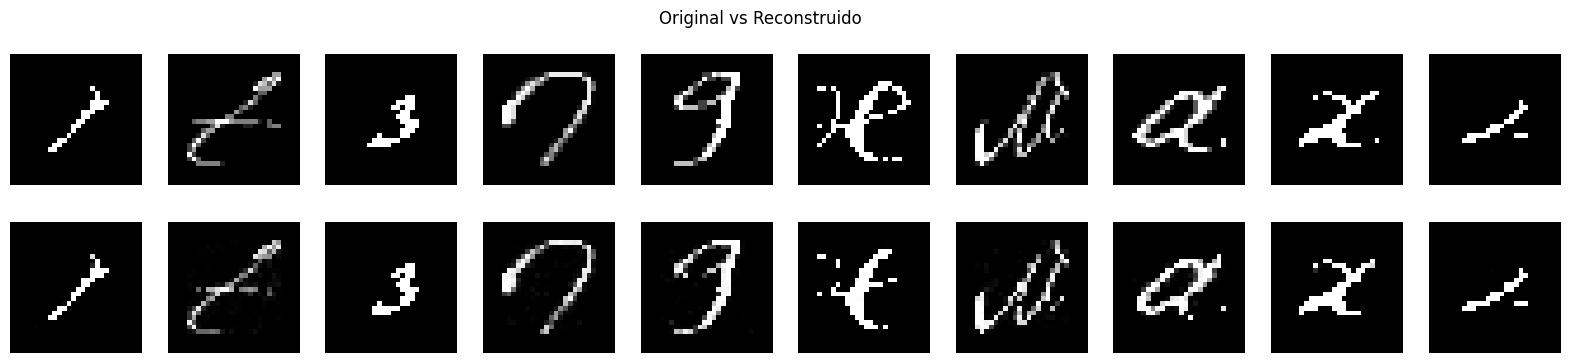

In [11]:
def plot_reconstructions(X):
    x_sample = X[:10]
    x_recon = autoencoder.predict(x_sample)
    x_sample = x_sample.reshape(-1, 28, 28)
    x_recon = x_recon.reshape(-1, 28, 28)
    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(x_sample[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i+11)
        plt.imshow(x_recon[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Original vs Reconstruido")
    plt.show()

plot_reconstructions(X)

In [64]:
Z = encoder.predict(X)
Z_norm = StandardScaler().fit_transform(Z)
n_letras = 47
n_total = len(X)
y = np.array(list(islice(cycle(range(n_letras)), n_total)))
n_clases = len(np.unique(y))
kmeans = KMeans(n_clusters=n_letras, random_state=42).fit(Z_norm)
labels_km = kmeans.labels_

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [65]:
ari = adjusted_rand_score(y, labels_km)
ami = adjusted_mutual_info_score(y, labels_km)
print(f"\nEvaluación Clustering → ARI: {ari:.4f} | AMI: {ami:.4f}\n")


Evaluación Clustering → ARI: -0.0014 | AMI: -0.0079



c:\Users\A03427\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


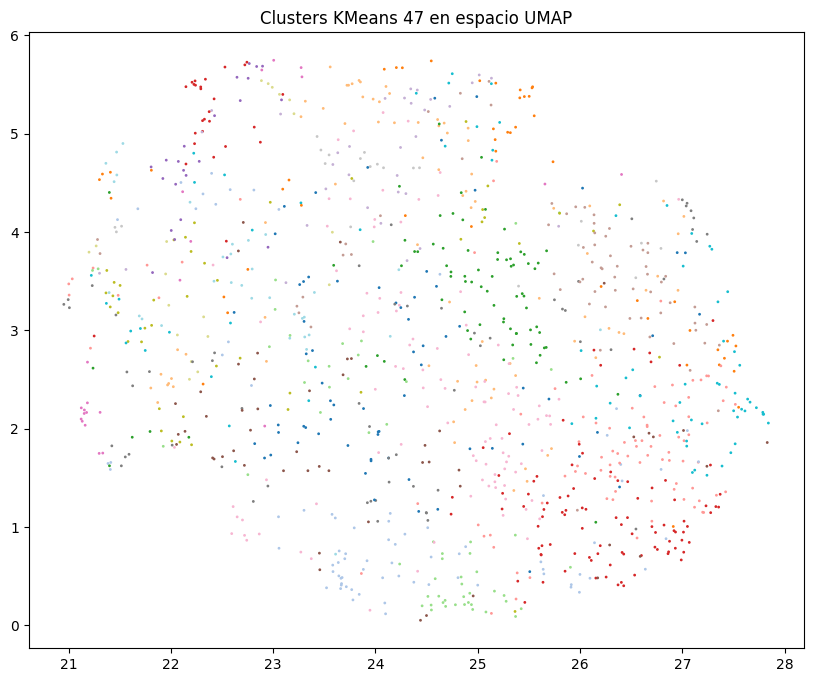

In [66]:
reduced = umap.UMAP(n_components=2, random_state=42).fit_transform(Z_norm)
plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels_km, cmap='tab20', s=1)
plt.title('Clusters KMeans ' + str(n_clases) + ' en espacio UMAP')
plt.show()

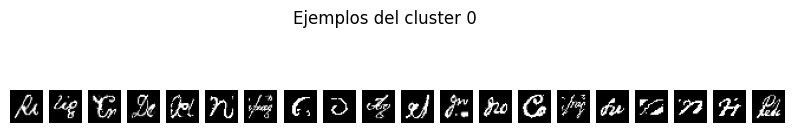

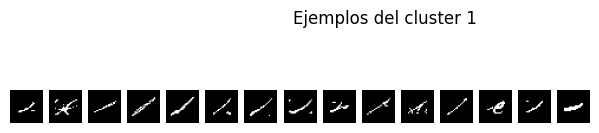

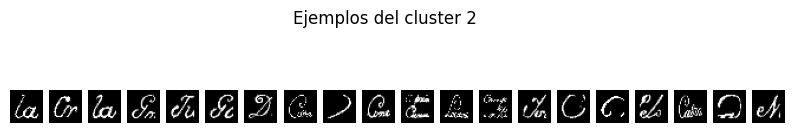

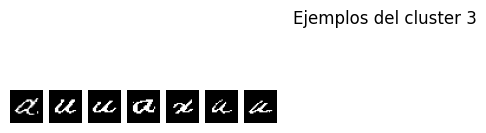

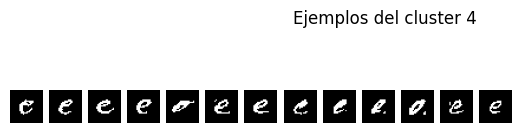

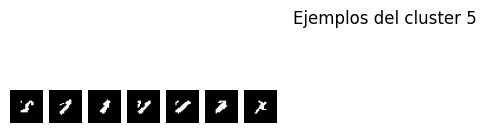

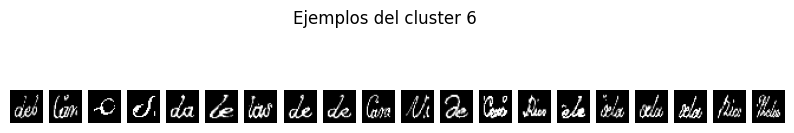

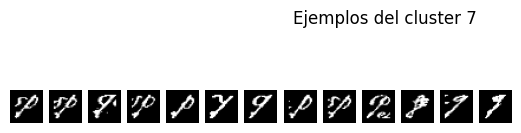

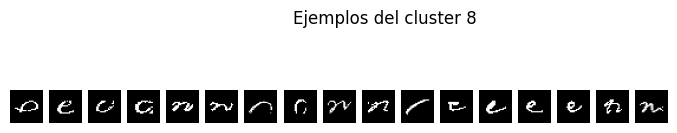

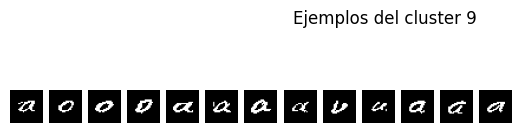

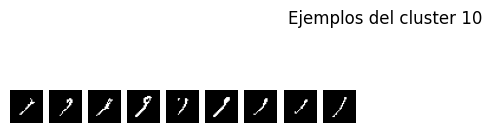

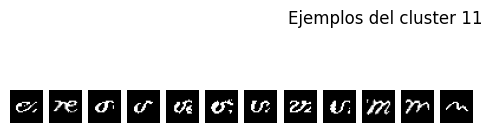

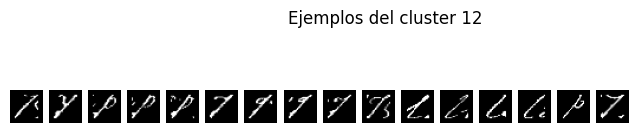

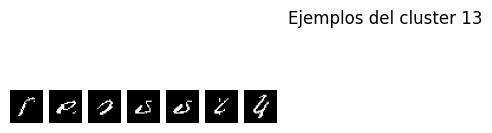

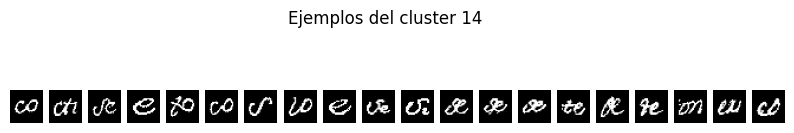

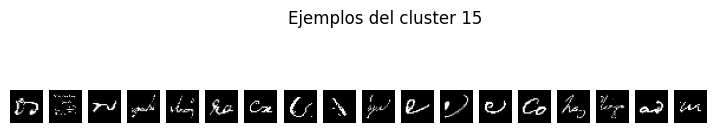

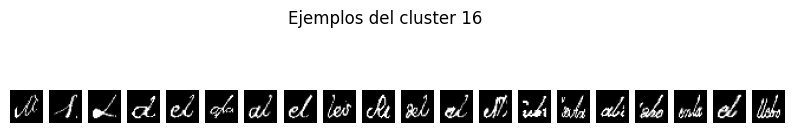

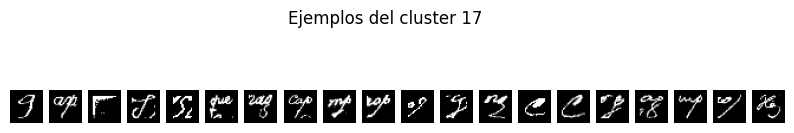

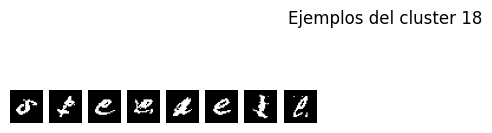

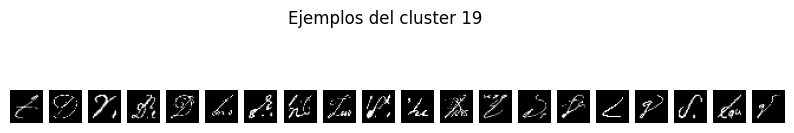

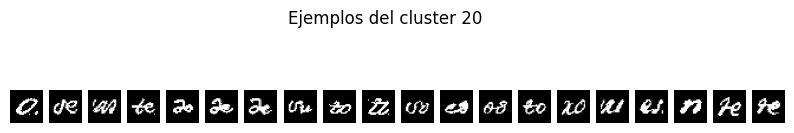

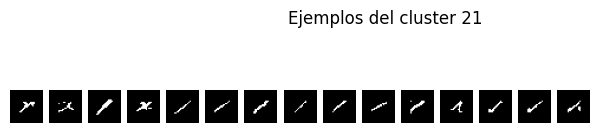

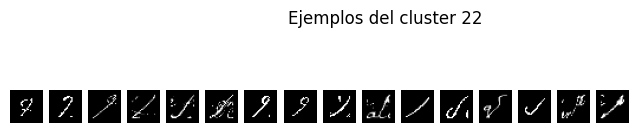

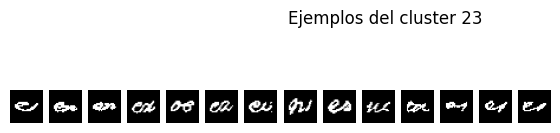

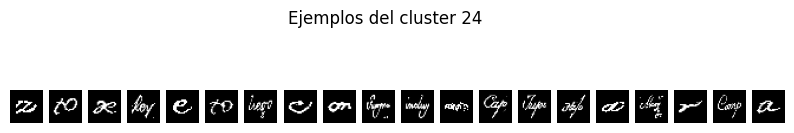

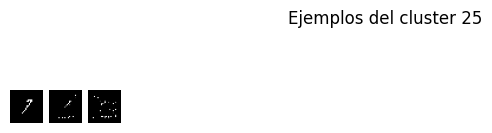

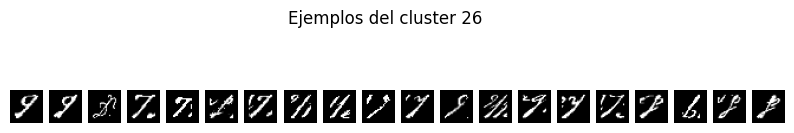

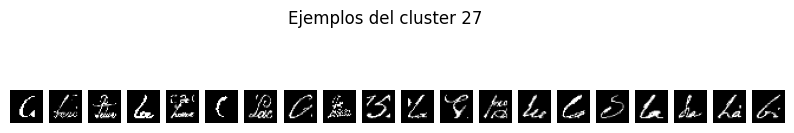

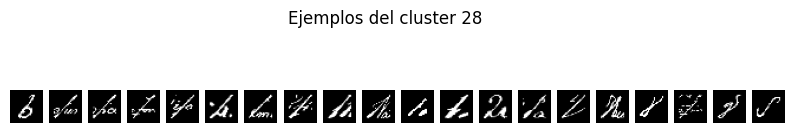

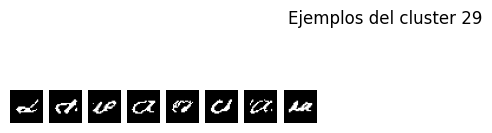

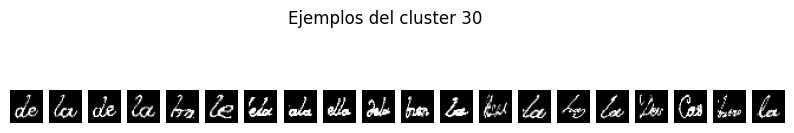

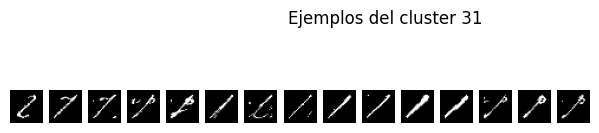

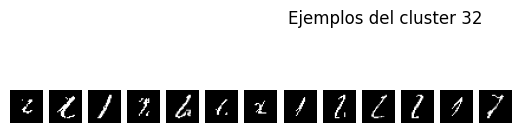

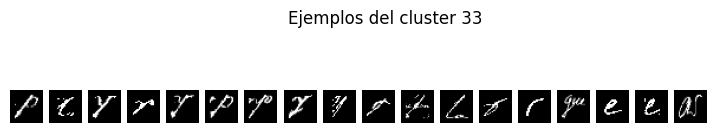

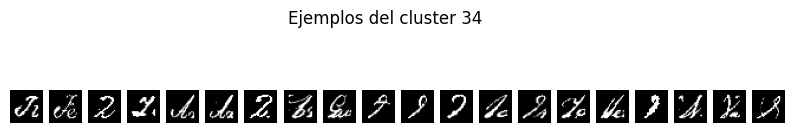

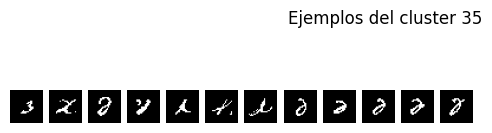

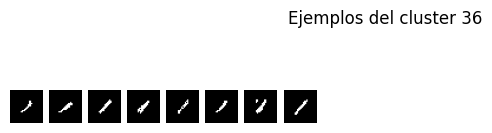

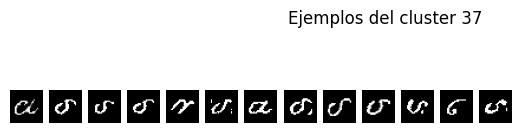

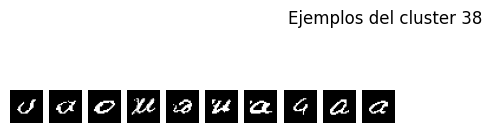

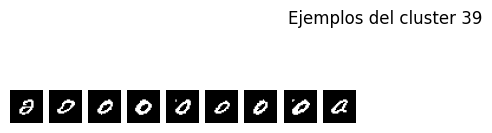

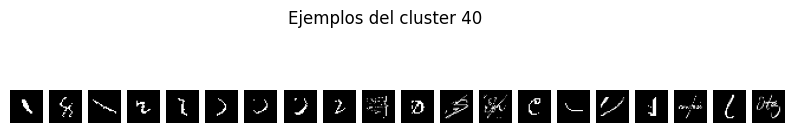

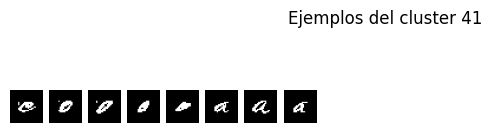

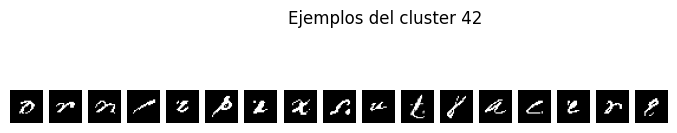

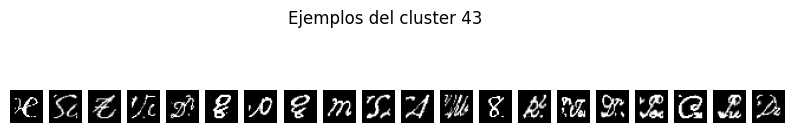

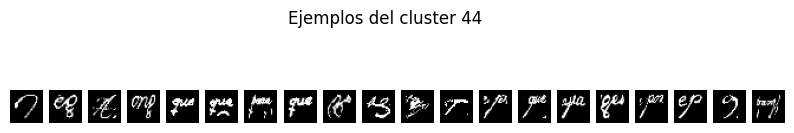

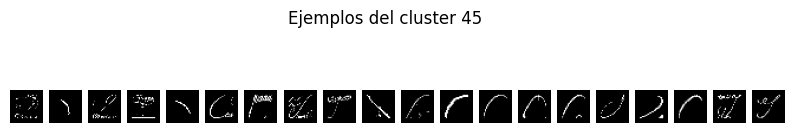

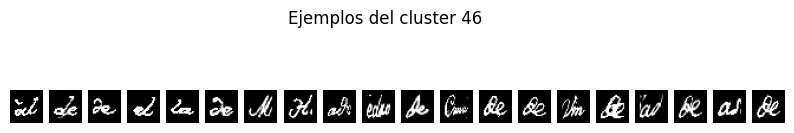

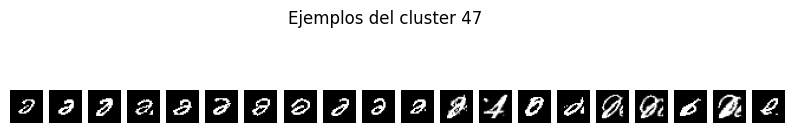

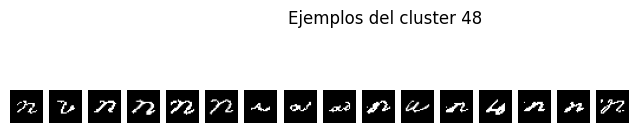

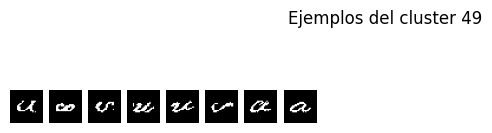

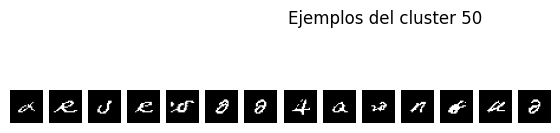

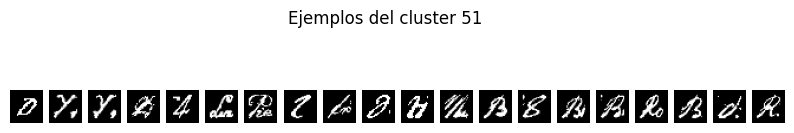

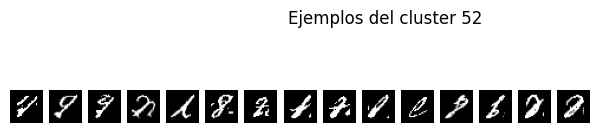

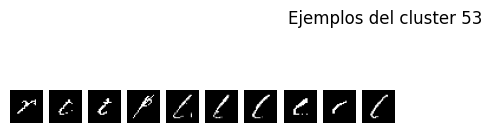

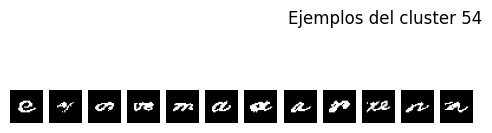

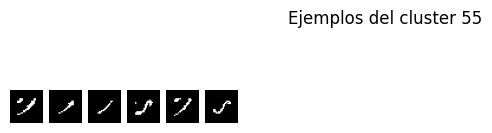

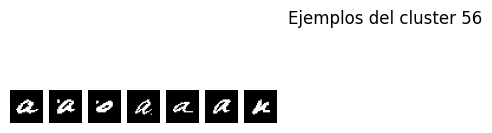

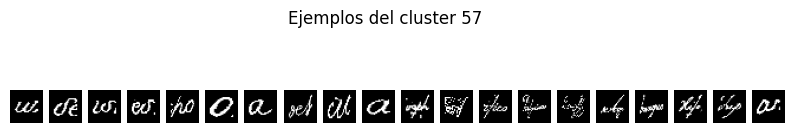

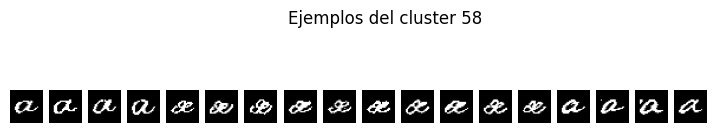

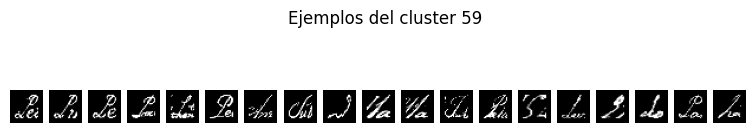

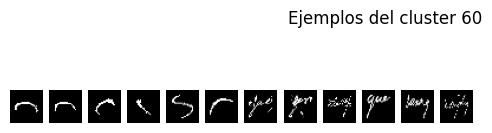

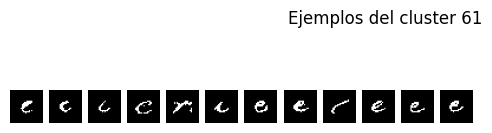

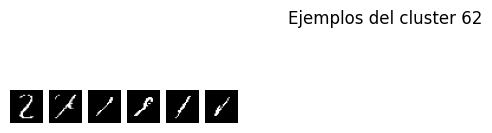

In [12]:
def show_examples_per_cluster(X, labels, cluster_id, n=20):
    idxs = np.where(labels == cluster_id)[0][:n]
    imgs = X[idxs].reshape(-1, 28, 28)
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Ejemplos del cluster {cluster_id}")
    plt.show()

for i in range(63):
    show_examples_per_cluster(X, labels_km, i)

In [13]:
np.savez("embeddings_dataset.npz", X=Z, y=y, cluster=labels_km)
joblib.dump(kmeans, "kmeans_model.pkl")
autoencoder.save("autoencoder_model.h5")


NameError: name 'y' is not defined


=== Cluster 0 ===


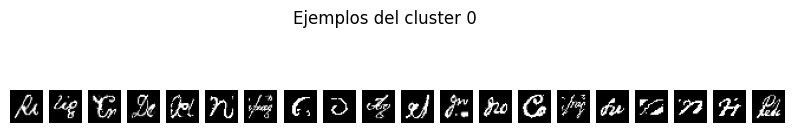

Cluster 0 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 1 ===


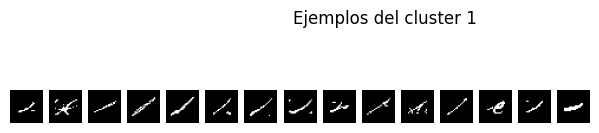

Cluster 1 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 2 ===


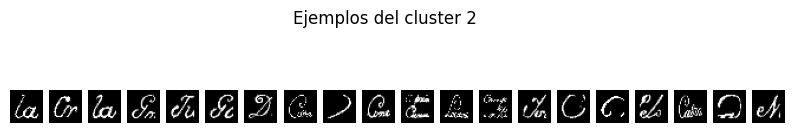

Cluster 2 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 3 ===


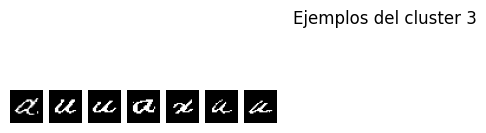

Cluster 3 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 4 ===


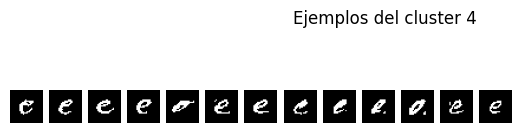

Cluster 4 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 5 ===


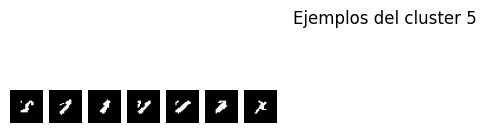

Cluster 5 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 6 ===


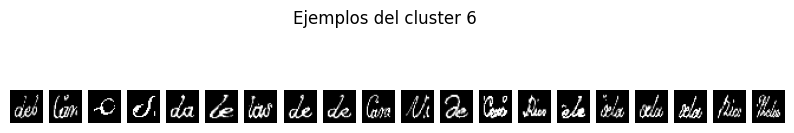

Cluster 6 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 7 ===


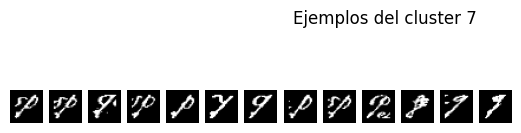

Cluster 7 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 8 ===


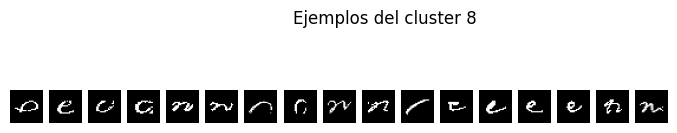

Cluster 8 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 9 ===


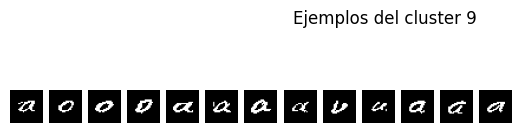

Cluster 9 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 10 ===


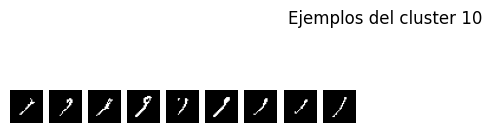

Cluster 10 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 11 ===


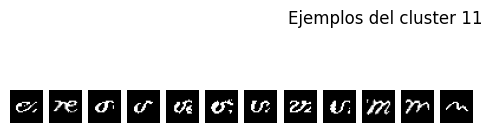

Cluster 11 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 12 ===


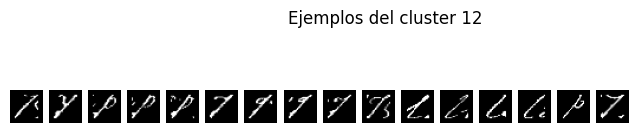

Cluster 12 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 13 ===


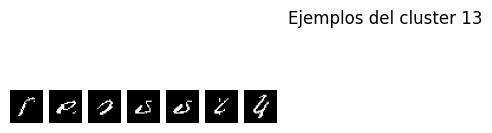

Cluster 13 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 14 ===


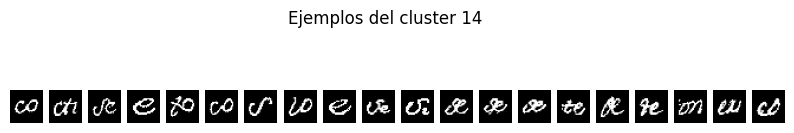

Cluster 14 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 15 ===


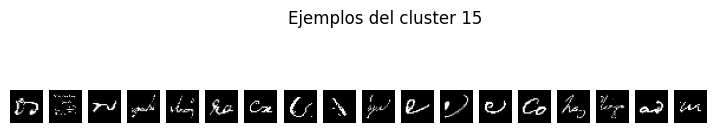

Cluster 15 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 16 ===


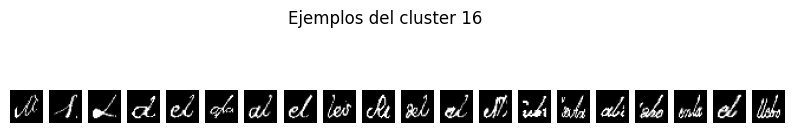

Cluster 16 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 17 ===


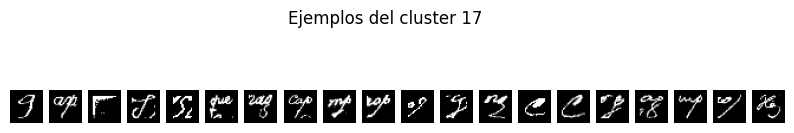

Cluster 17 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 18 ===


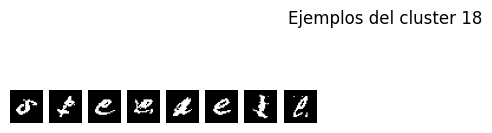

Cluster 18 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 19 ===


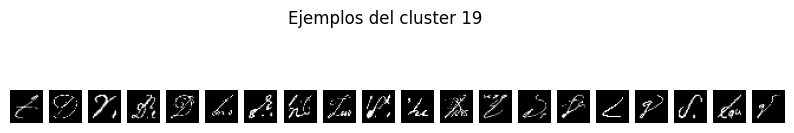

Cluster 19 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 20 ===


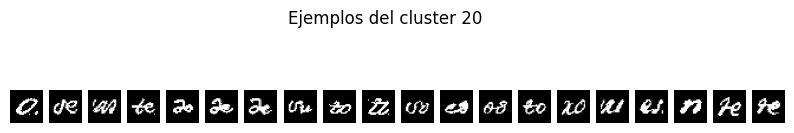

Cluster 20 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 21 ===


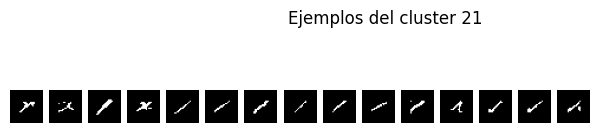

Cluster 21 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 22 ===


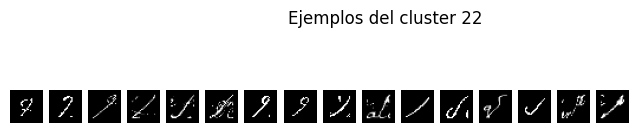

Cluster 22 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 23 ===


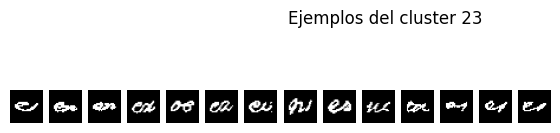

Cluster 23 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 24 ===


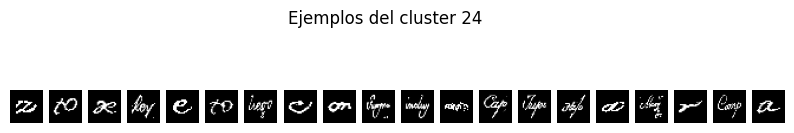

Cluster 24 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 25 ===


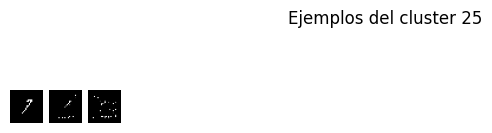

Cluster 25 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 26 ===


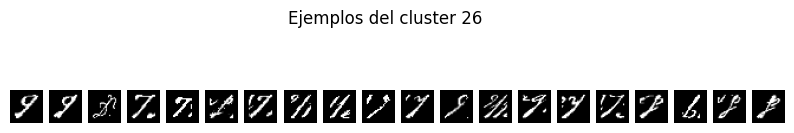

Cluster 26 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 27 ===


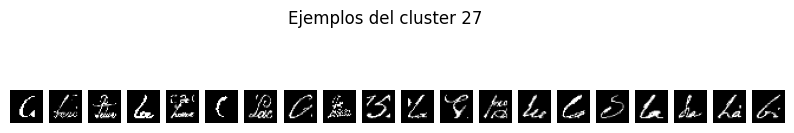

Cluster 27 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 28 ===


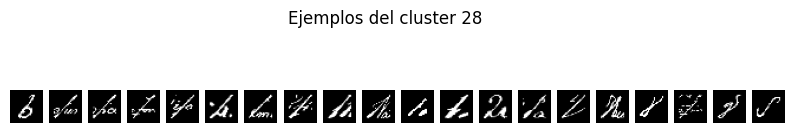

Cluster 28 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 29 ===


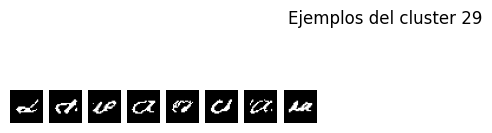

Cluster 29 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 30 ===


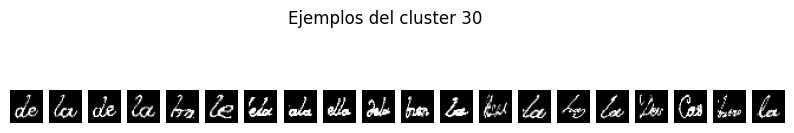

Cluster 30 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 31 ===


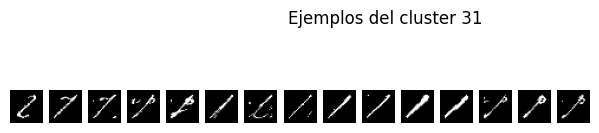

Cluster 31 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 32 ===


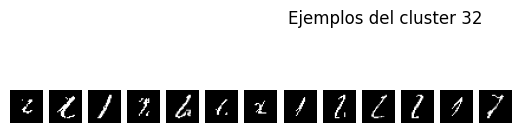

Cluster 32 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 33 ===


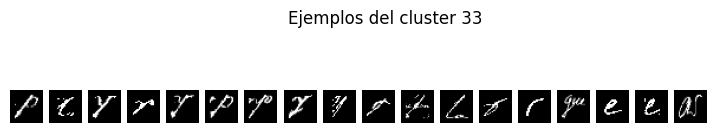

Cluster 33 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 34 ===


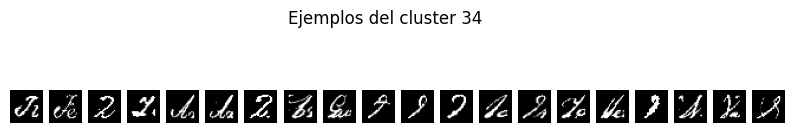

Cluster 34 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 35 ===


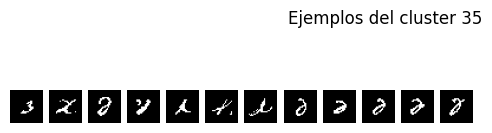

Cluster 35 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 36 ===


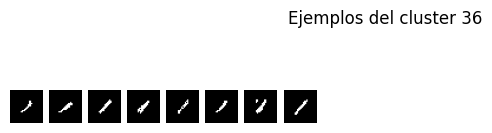

Cluster 36 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 37 ===


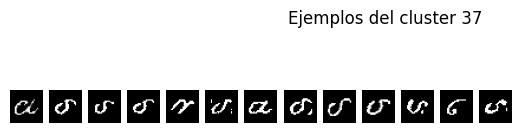

Cluster 37 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 38 ===


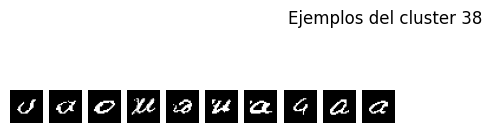

Cluster 38 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 39 ===


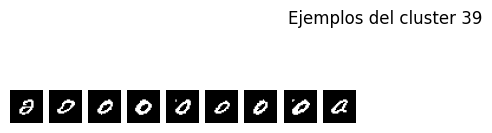

Cluster 39 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 40 ===


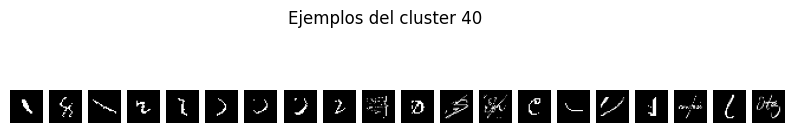

Cluster 40 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 41 ===


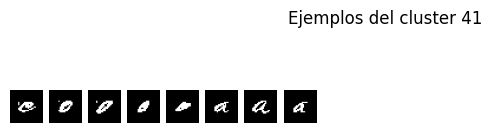

Cluster 41 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 42 ===


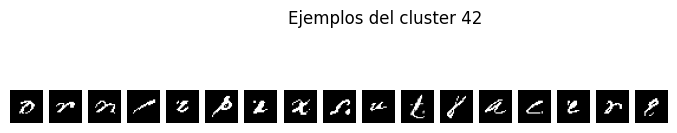

Cluster 42 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 43 ===


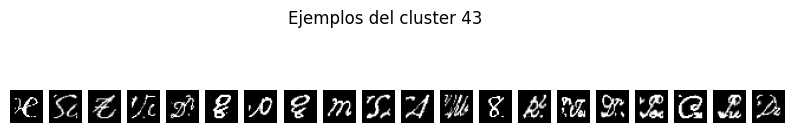

Cluster 43 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 44 ===


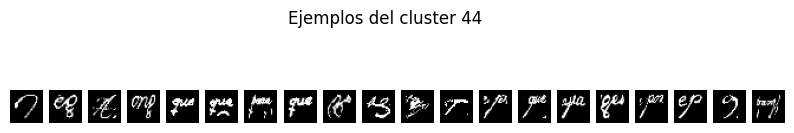

Cluster 44 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 45 ===


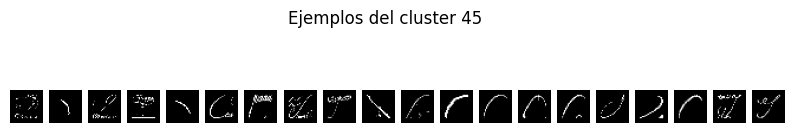

Cluster 45 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 46 ===


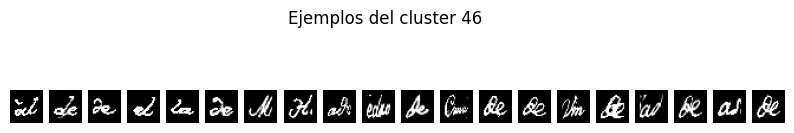

Cluster 46 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 47 ===


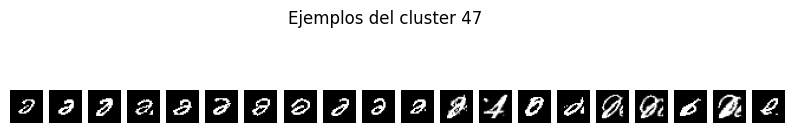

Cluster 47 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 48 ===


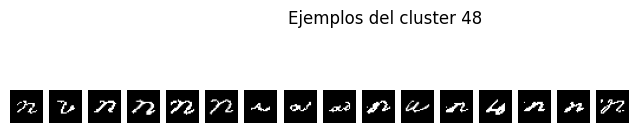

Cluster 48 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 49 ===


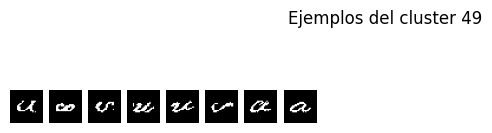

Cluster 49 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 50 ===


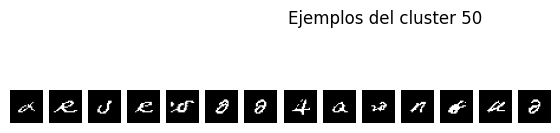

Cluster 50 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 51 ===


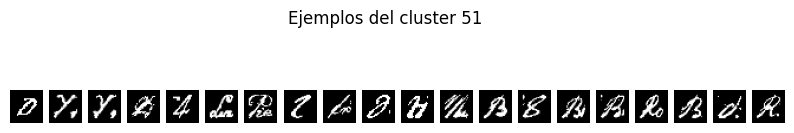

Cluster 51 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 52 ===


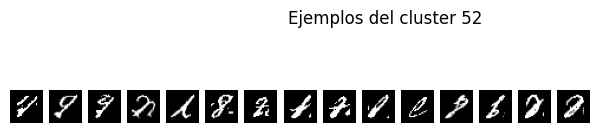

Cluster 52 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 53 ===


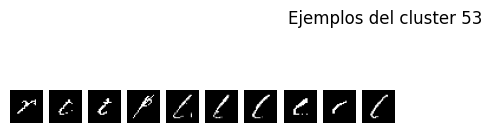

Cluster 53 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 54 ===


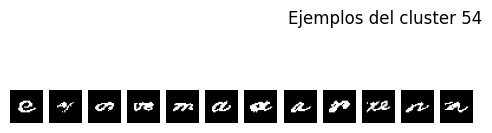

Cluster 54 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 55 ===


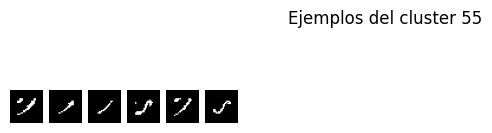

Cluster 55 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 56 ===


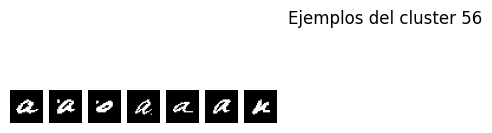

Cluster 56 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 57 ===


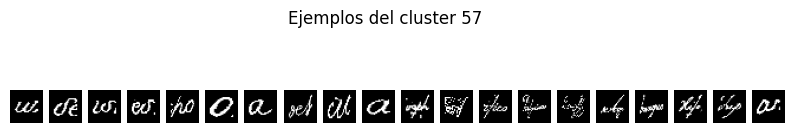

Cluster 57 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 58 ===


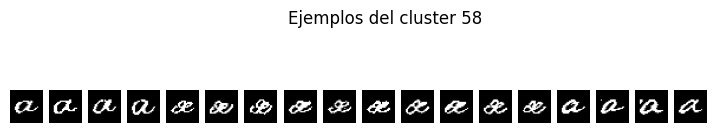

Cluster 58 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 59 ===


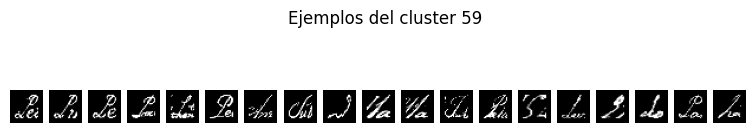

Cluster 59 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 60 ===


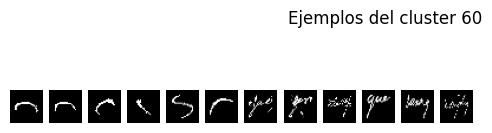

Cluster 60 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 61 ===


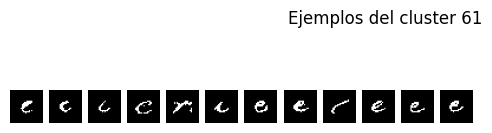

Cluster 61 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())


=== Cluster 62 ===


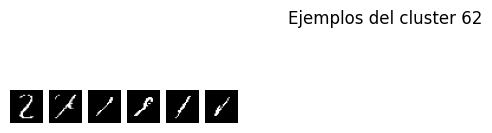

Cluster 62 — ¿Qué representa?


Text(value='', description='Etiqueta:')

Button(description='Guardar', style=ButtonStyle())

In [34]:
def asignar_etiquetas():
    etiquetas = {}

    def mostrar_cluster(cluster_id):
        show_examples_per_cluster(X, labels_km, cluster_id)
        print(f"Cluster {cluster_id} — ¿Qué representa?")
        texto = widgets.Text(description='Etiqueta:')
        display(texto)

        def guardar_etiqueta(b):
            etiquetas[cluster_id] = texto.value
            print(f"Guardado: {cluster_id} → {texto.value}")

        boton = widgets.Button(description="Guardar")
        boton.on_click(guardar_etiqueta)
        display(boton)

    for i in range(63):
        print(f"\n=== Cluster {i} ===")
        mostrar_cluster(i)

    return etiquetas

etiquetas = asignar_etiquetas()

In [ ]:
cluster_to_label = {
    0: 'O', 1: 'v', 2: 'd', 3: 'l', 4: 'I', 5: 'L', 6: '3', 7: 'b', 8: 'D', 9: 'G',   
    10: 'g', 11: 'T', 12: '7', 13: 'C', 14: '?', 15: 'O', 16: 'P', 17: 's', 18: 'r', 19: 'h',   
    20: 'R', 21: '6', 22: 'Q', 23: 'H', 24: '8', 25: 'g',  
    26: 'G', 27: 'u', 28: 'W', 29: 'E', 30: 'E', 31: 'd', 32: 'H', 33: '7', 34: 'e', 35: 's',  
    36: 'T', 37: 'O', 38: 'X', 39: 'A', 40: 'm', 41: 'f', 42: 'S', 43: 'H', 44: 'a', 45: 'A',    
    46: 'h', 47: 'e', 48: 'v', 49: '4', 50: 'M', 51: 'I',   
    52: 'Q', 53: '5', 54: 'F', 55: 'g', 56: 'm', 57: 'W', 58: 'P', 59: 't', 60: 'H', 61: 'V',    
    62: 'h'  
}


with open("cluster_labels.json", "w") as f:
    json.dump(cluster_to_label, f)


In [ ]:
def extract_characters_from_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if 10 < w < 100 and 10 < h < 100:
            boxes.append((x, y, w, h))

    boxes = sorted(boxes, key=lambda b: (b[1] // 30, b[0]))

    chars = []
    for (x, y, w, h) in boxes:
        char = thresh[y:y+h, x:x+w]

        # Centrar en canvas 28x28
        canvas = np.zeros((28, 28), dtype=np.uint8)
        char = cv2.resize(char, (min(w, 20), min(h, 20)))
        cx, cy = char.shape[1] // 2, char.shape[0] // 2
        x_offset = (28 // 2) - cx
        y_offset = (28 // 2) - cy
        canvas[y_offset:y_offset+char.shape[0], x_offset:x_offset+char.shape[1]] = char

        chars.append(canvas)
    
    return chars

In [37]:
def predict_char(img28):
    img = img28.astype('float32') / 255.0
    img = np.transpose(img)  # EMNIST está transpuesta
    img = img.flatten().reshape(1, -1)
    embedding = encoder.predict(img)
    cluster = kmeans.predict(embedding)[0]
    return cluster_to_label.get(str(cluster), '?')

In [38]:
def recognize_text_from_image(image_path):
    chars = extract_characters_from_image(image_path)
    predictions = [predict_char(c) for c in chars]
    return "".join(predictions)

In [39]:
def show_segmented_characters(image_path):
    chars = extract_characters_from_image(image_path)
    plt.figure(figsize=(20, 3))
    for i, char in enumerate(chars):
        plt.subplot(1, len(chars), i+1)
        plt.imshow(char, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Caracteres segmentados de {os.path.basename(image_path)}")
    plt.show()

In [40]:
def debug_character_detection(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title("Escalada")
    plt.axis('off')
    plt.show()

    # Dibujar contornos
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    debug = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        if 5 < w < 100 and 5 < h < 100:
            cv2.rectangle(debug, (x, y), (x+w, y+h), (0,255,0), 1)

    plt.figure(figsize=(12, 6))
    plt.imshow(debug)
    plt.title(f"Contornos detectados en {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()


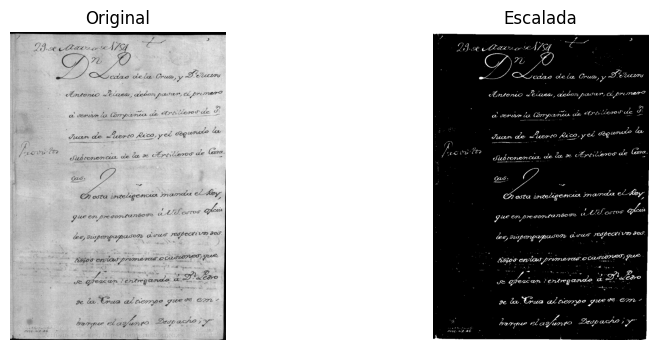

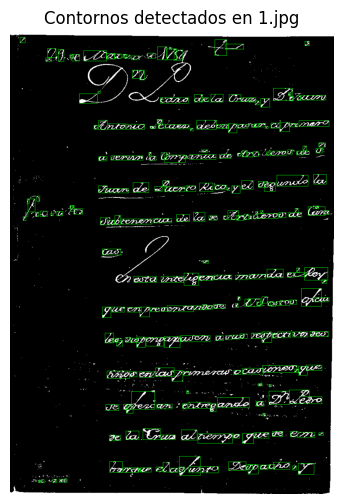

In [41]:
debug_character_detection("Imagenes_Pares/1.jpg")


In [42]:
def sort_boxes_linewise(boxes, line_tol_factor=0.7):
    if not boxes:
        return []

    boxes = sorted(boxes, key=lambda b: b[1])
    lines = []
    current_line = []
    _, y0, _, h0 = boxes[0]
    current_line.append(boxes[0])
    avg_height = h0

    for box in boxes[1:]:
        _, y, _, h = box
        if abs(y - y0) < line_tol_factor * avg_height:
            current_line.append(box)
        else:
            lines.append(sorted(current_line, key=lambda b: b[0]))
            current_line = [box]
            y0 = y
            avg_height = h

    lines.append(sorted(current_line, key=lambda b: b[0]))
    return [box for line in lines for box in line]

In [43]:
def segment_characters_from_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area < 150:
            continue
        aspect_ratio = w / h
        if aspect_ratio < 0.2 or aspect_ratio > 2.5:
            continue
        boxes.append((x, y, w, h))

    boxes = sort_boxes_linewise(boxes)

    chars = []
    for x, y, w, h in boxes:
        char = thresh[y:y+h, x:x+w]

        canvas = np.zeros((28, 28), dtype=np.uint8)
        char = cv2.resize(char, (min(w, 20), min(h, 20)))
        cx, cy = char.shape[1] // 2, char.shape[0] // 2
        x_offset = (28 // 2) - cx
        y_offset = (28 // 2) - cy
        canvas[y_offset:y_offset+char.shape[0], x_offset:x_offset+char.shape[1]] = char

        canvas = canvas.astype('float32') / 255.0
        canvas = np.transpose(canvas)
        chars.append(canvas.flatten())
    
    return np.array(chars), boxes


In [44]:
def predict_text_from_image(image_path, encoder, kmeans, cluster_to_label, space_threshold=20, line_tol_factor=0.5):
    chars, boxes = segment_characters_from_image(image_path)
    if len(chars) == 0:
        return ''

    embeddings = encoder.predict(chars)
    clusters = kmeans.predict(embeddings)
    letters = [cluster_to_label.get(c, '?') for c in clusters]

    # Agrupar por líneas
    lines = []
    current_line = []
    sorted_data = sorted(zip(boxes, letters), key=lambda bl: bl[0][1])  # ordenar por y

    y0 = sorted_data[0][0][1]
    h0 = sorted_data[0][0][3]
    avg_height = h0

    for (box, letter) in sorted_data:
        x, y, w, h = box
        if abs(y - y0) < line_tol_factor * avg_height:
            current_line.append((box, letter))
        else:
            lines.append(current_line)
            current_line = [(box, letter)]
            y0 = y
            avg_height = h
    lines.append(current_line)

    # Dentro de cada línea, ordenar por X y calcular espacios
    final_text = ""
    for line in lines:
        line = sorted(line, key=lambda bl: bl[0][0])  # ordenar por x
        line_text = line[0][1]
        for i in range(1, len(line)):
            x_prev, _, w_prev, _ = line[i - 1][0]
            x_curr, _, _, _ = line[i][0]
            gap = x_curr - (x_prev + w_prev)
            if gap > space_threshold:
                line_text += ' '
            line_text += line[i][1]
        final_text += line_text + '\n'

    return final_text.strip()



In [45]:
print(cluster_to_label.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])


In [55]:
image_path = "imagenes_pares/1.jpg"
texto = predict_text_from_image(image_path, encoder, kmeans, cluster_to_label)
print("Texto detectado:\n", texto)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Texto detectado:
 T 7
gO d gTvdA
5 gT 5
gdT
g Q 7
tH Oh5
d
7 I QgV5 g6
T
g
H 5T6 g
h g
d
h A H AhO
G g 5 h7
T
T A
a g v
5 d g
v O H 5f
Ag
d
E AV H
f h
TdVVHT
d d 5G
HT
7 T dfs A5
Q LTT
LgGHdA
7d V 7
f 5
g dd
g
rGg f O
GH W g Hs
GV f
t d d Og7sVH A
gggICG


In [56]:
def debug_prediction_by_char(image_path):
    chars = extract_characters_from_image(image_path)
    for i, char in enumerate(chars):
        plt.imshow(char, cmap='gray')
        plt.title(f"Char {i}")
        plt.axis('off')
        plt.show()

        img = char.astype('float32') / 255.0
        img = np.transpose(img).flatten().reshape(1, -1)
        embedding = encoder.predict(img)
        cluster = kmeans.predict(embedding)[0]
        print(f"→ Cluster: {cluster} → Letra: {cluster_to_label.get(cluster, '?')}")

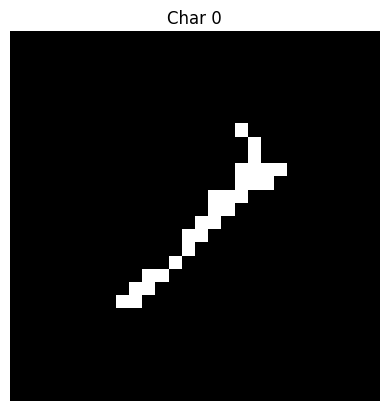

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
→ Cluster: 36 → Letra: T


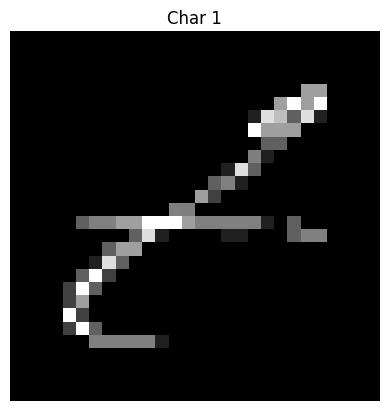

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
→ Cluster: 12 → Letra: 7


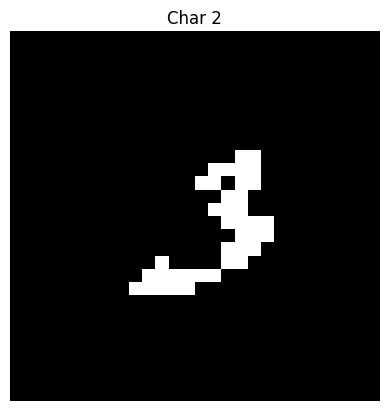

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
→ Cluster: 36 → Letra: T


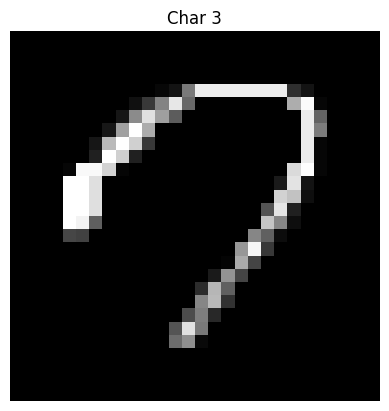

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
→ Cluster: 25 → Letra: g


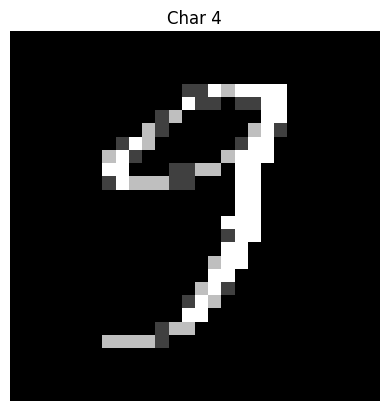

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
→ Cluster: 15 → Letra: O


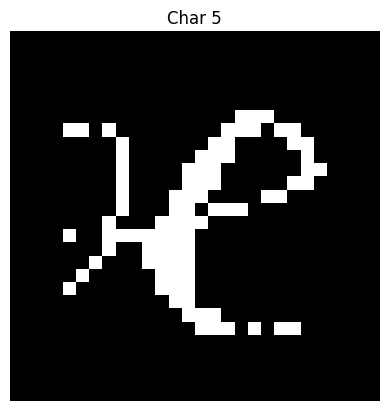

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
→ Cluster: 53 → Letra: 5


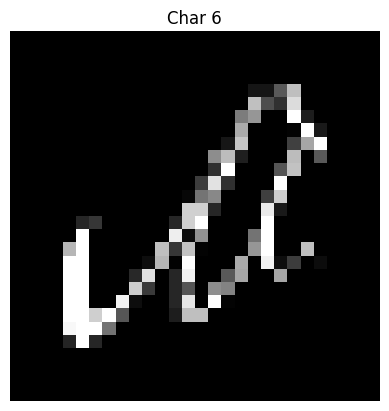

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
→ Cluster: 31 → Letra: d


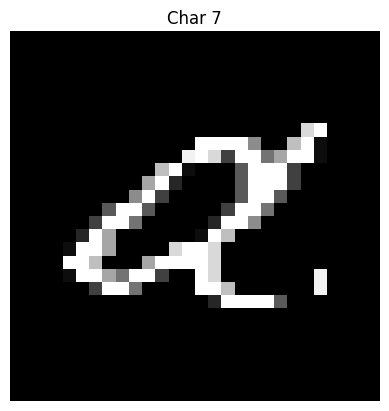

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
→ Cluster: 55 → Letra: g


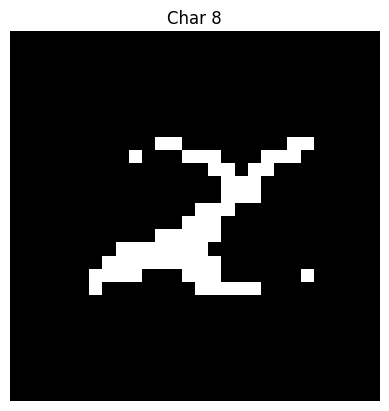

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
→ Cluster: 36 → Letra: T


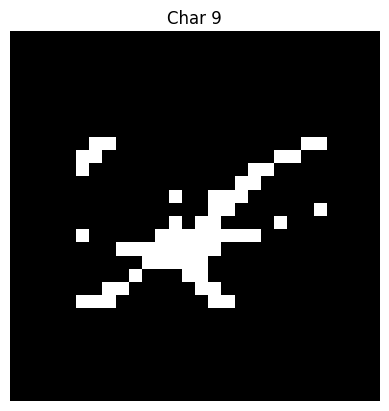

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
→ Cluster: 36 → Letra: T


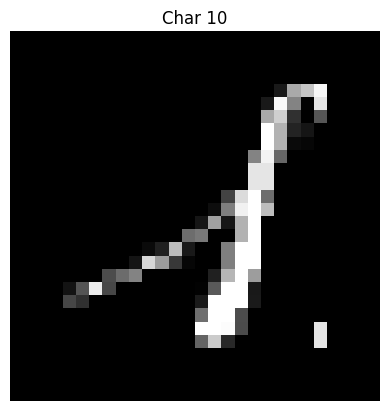

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
→ Cluster: 1 → Letra: v


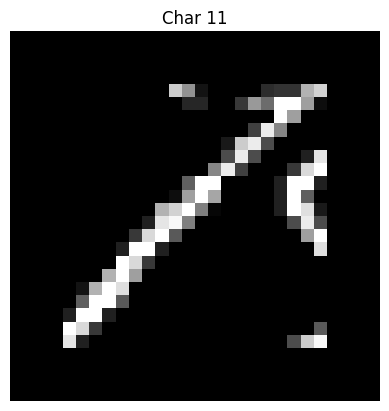

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
→ Cluster: 31 → Letra: d


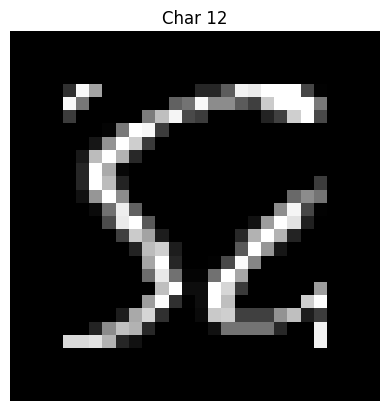

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
→ Cluster: 45 → Letra: A


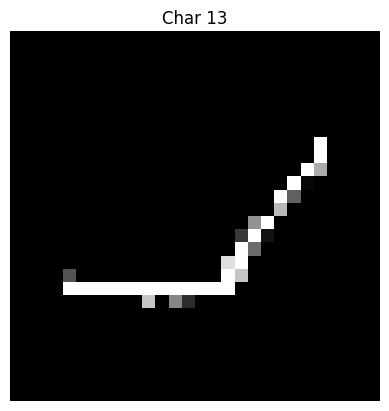

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
→ Cluster: 25 → Letra: g


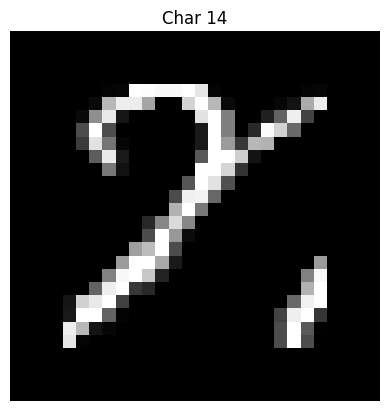

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
→ Cluster: 31 → Letra: d


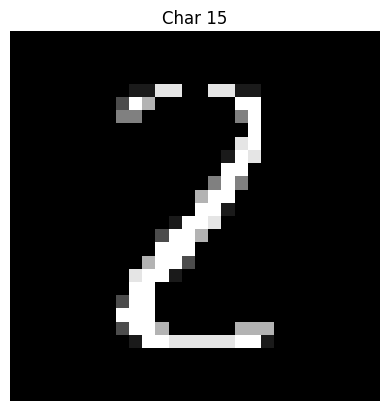

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
→ Cluster: 36 → Letra: T


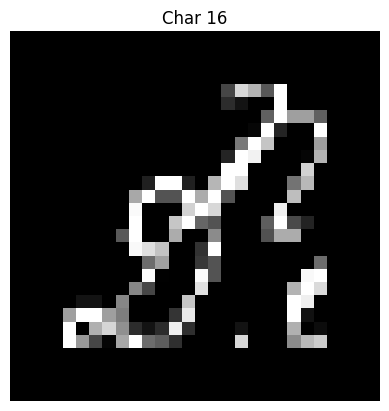

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
→ Cluster: 12 → Letra: 7


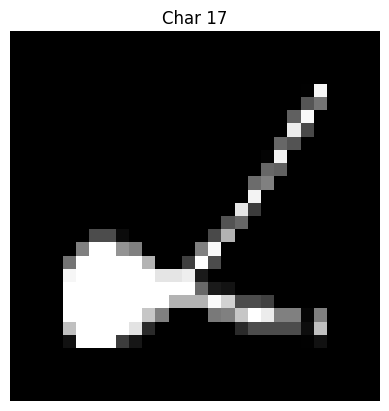

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
→ Cluster: 10 → Letra: g


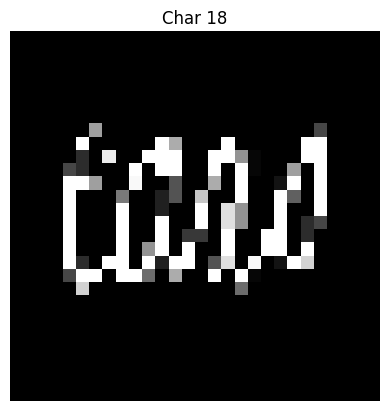

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
→ Cluster: 10 → Letra: g


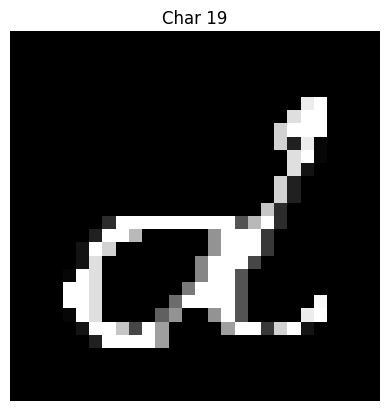

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
→ Cluster: 59 → Letra: t


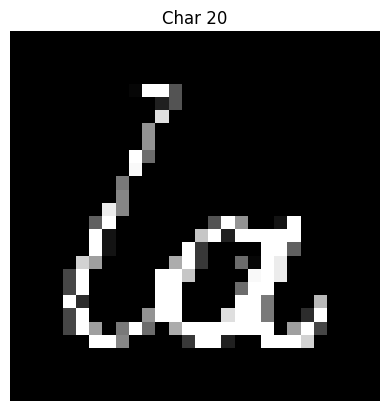

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
→ Cluster: 22 → Letra: Q


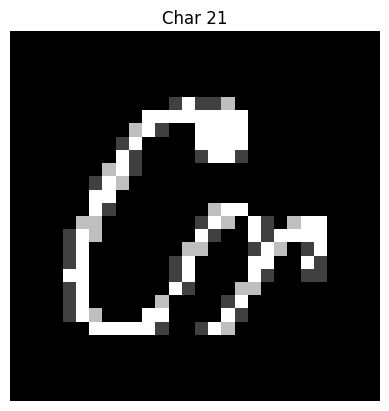

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
→ Cluster: 15 → Letra: O


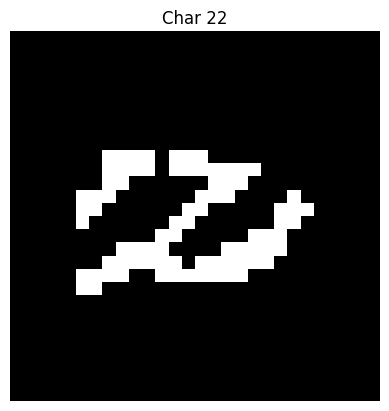

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
→ Cluster: 53 → Letra: 5


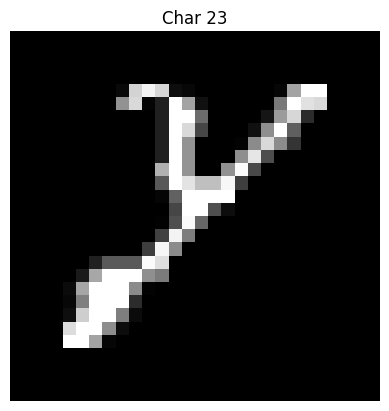

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
→ Cluster: 31 → Letra: d


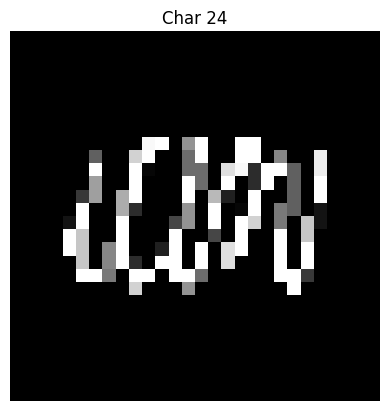

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
→ Cluster: 32 → Letra: H


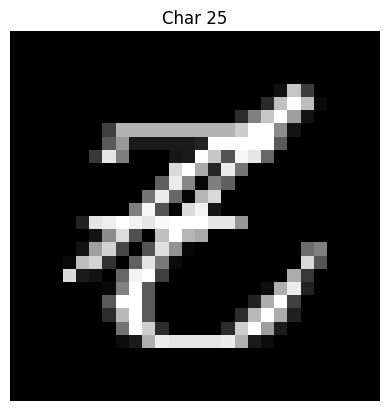

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
→ Cluster: 33 → Letra: 7


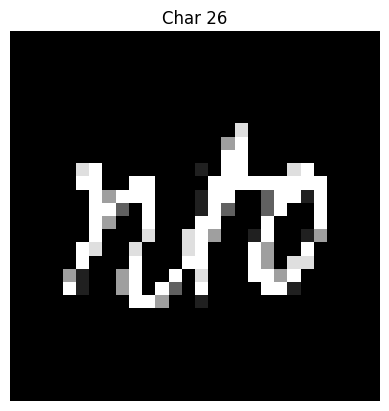

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
→ Cluster: 32 → Letra: H


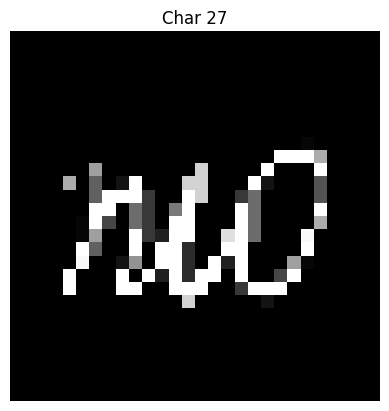

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
→ Cluster: 32 → Letra: H


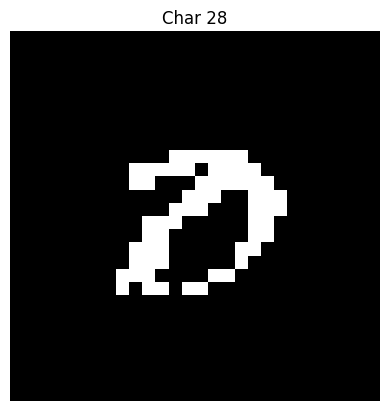

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
→ Cluster: 39 → Letra: A


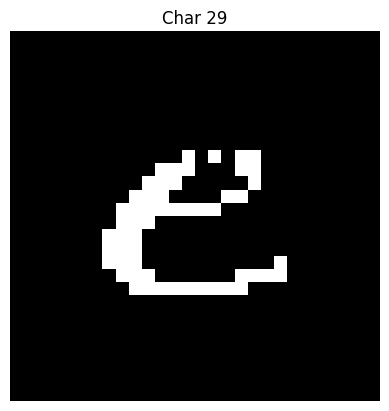

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
→ Cluster: 4 → Letra: I


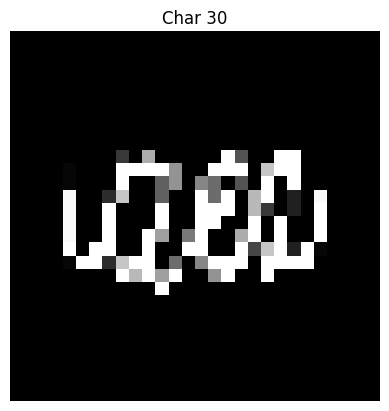

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
→ Cluster: 32 → Letra: H


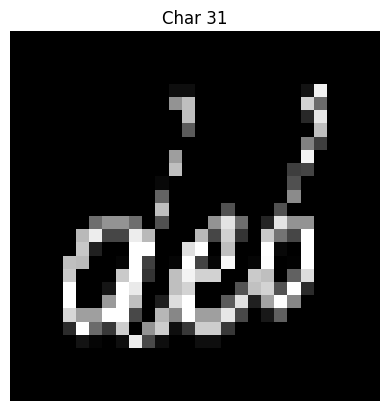

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
→ Cluster: 22 → Letra: Q


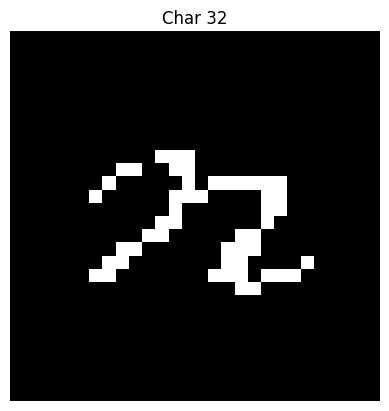

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
→ Cluster: 61 → Letra: V


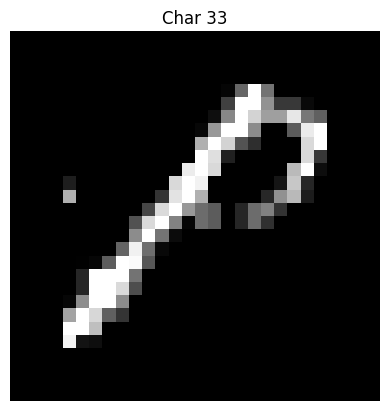

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
→ Cluster: 53 → Letra: 5


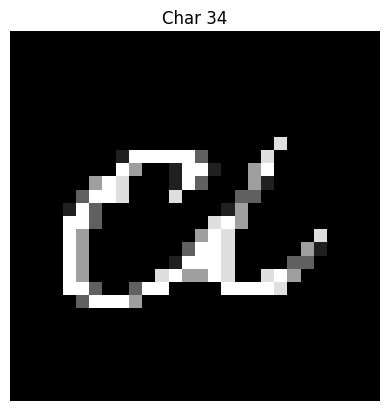

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
→ Cluster: 55 → Letra: g


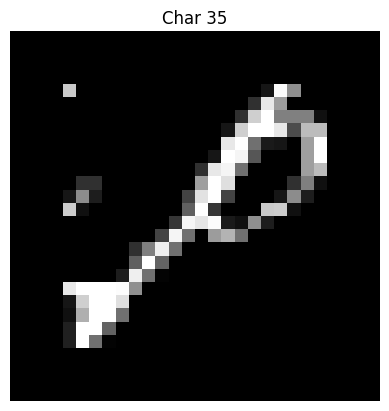

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 21 → Letra: 6


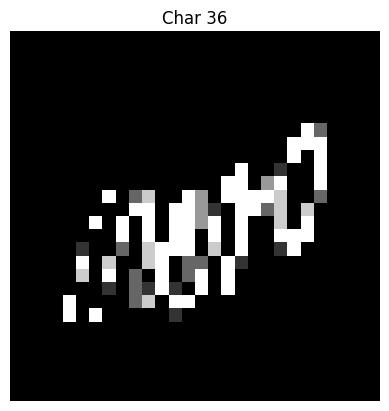

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 35 → Letra: s


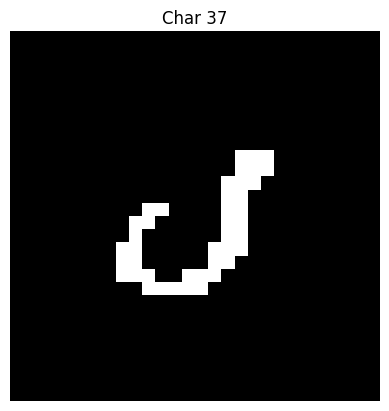

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
→ Cluster: 41 → Letra: f


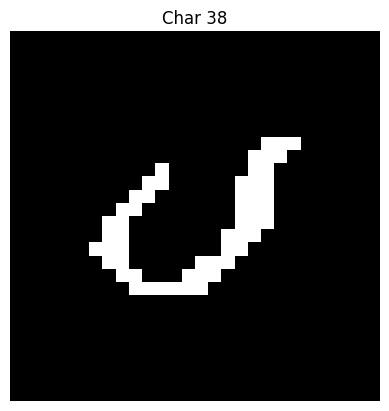

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 55 → Letra: g


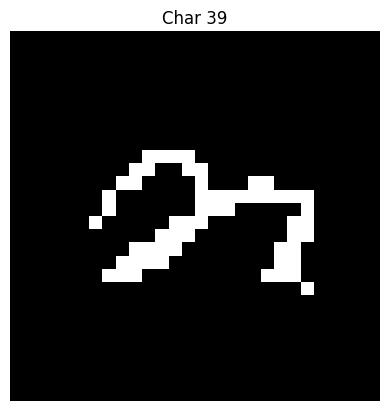

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
→ Cluster: 36 → Letra: T


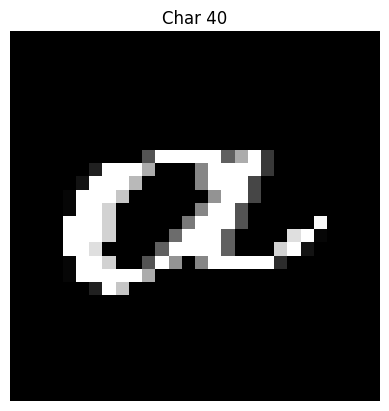

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 62 → Letra: h


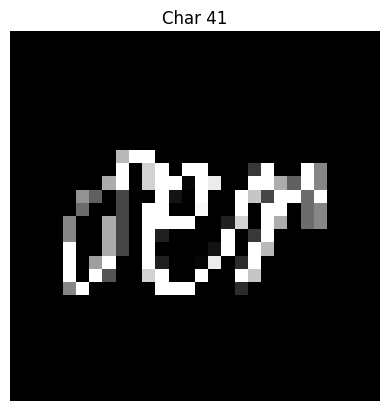

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
→ Cluster: 32 → Letra: H


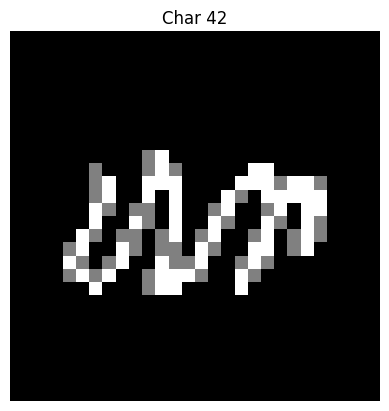

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
→ Cluster: 32 → Letra: H


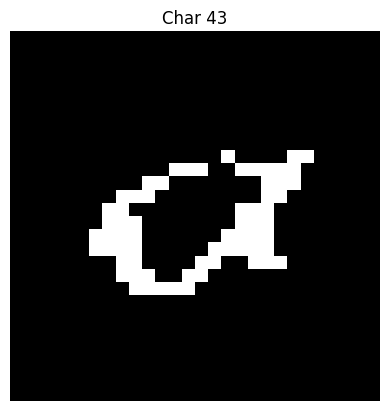

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
→ Cluster: 55 → Letra: g


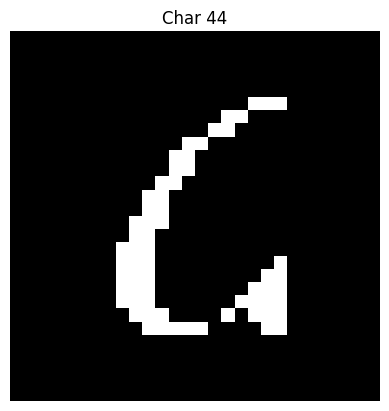

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
→ Cluster: 60 → Letra: H


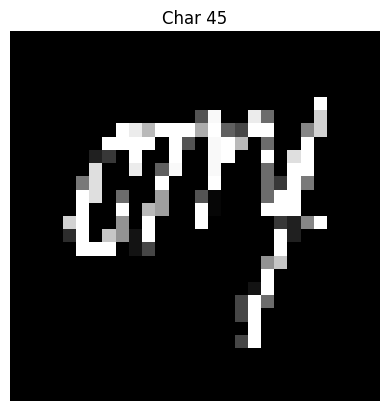

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
→ Cluster: 27 → Letra: u


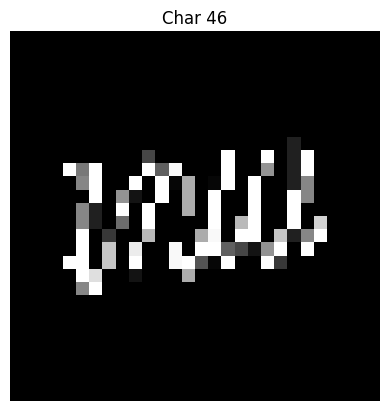

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
→ Cluster: 32 → Letra: H


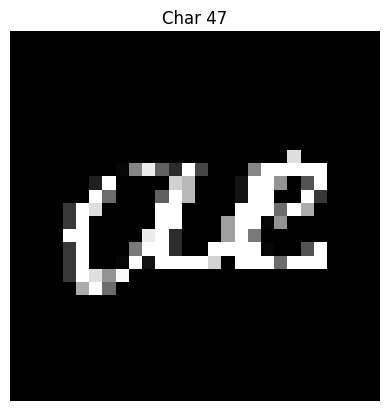

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
→ Cluster: 32 → Letra: H


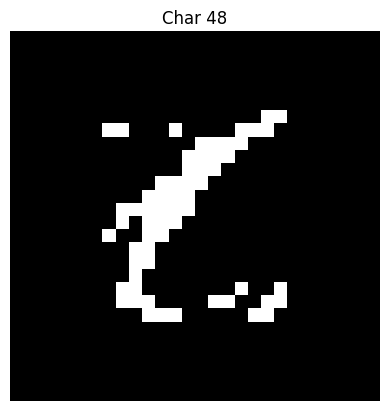

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
→ Cluster: 53 → Letra: 5


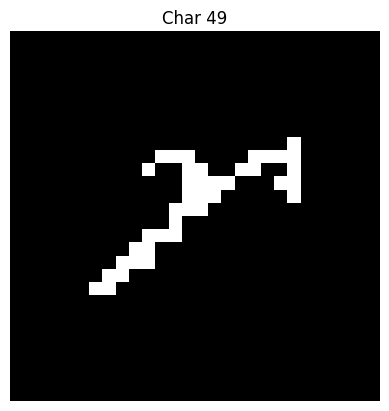

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
→ Cluster: 36 → Letra: T


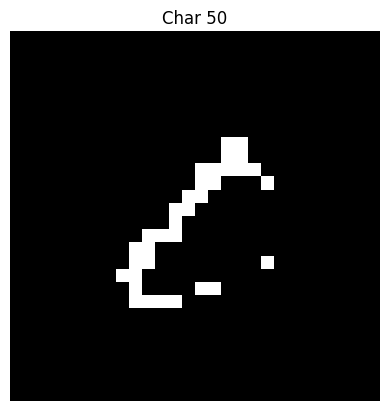

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
→ Cluster: 21 → Letra: 6


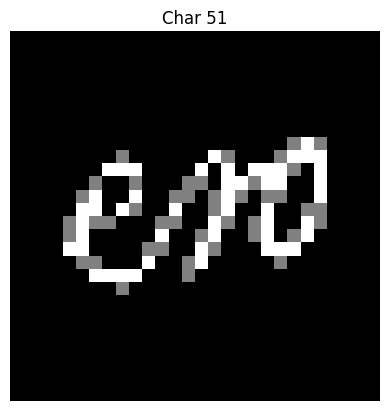

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
→ Cluster: 32 → Letra: H


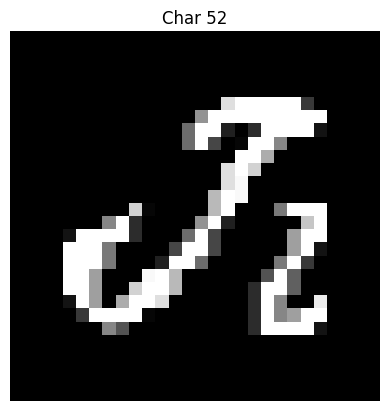

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
→ Cluster: 26 → Letra: G


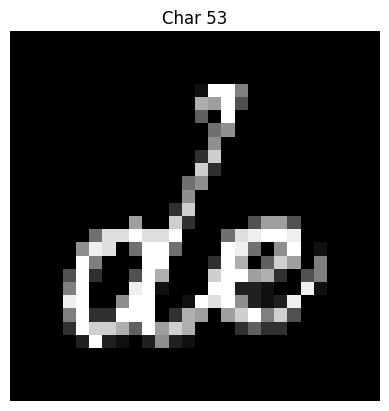

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
→ Cluster: 19 → Letra: h


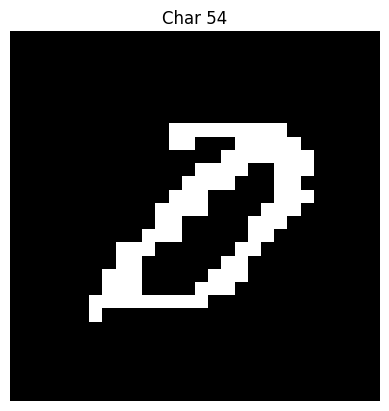

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 39 → Letra: A


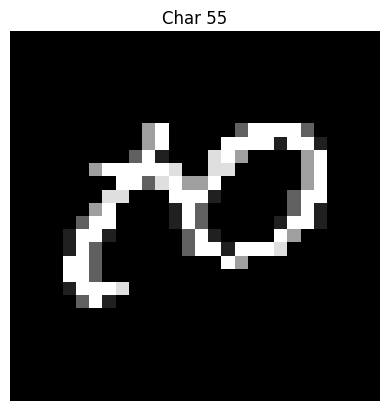

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 53 → Letra: 5


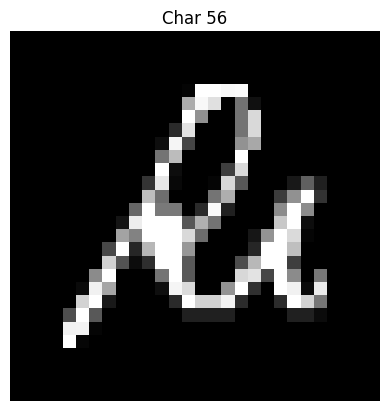

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
→ Cluster: 32 → Letra: H


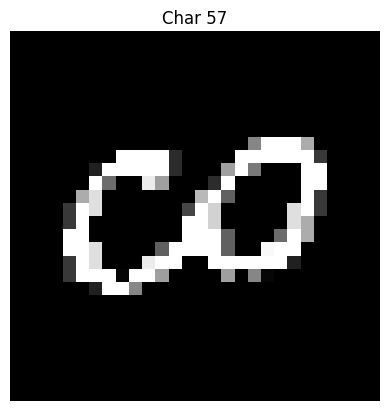

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
→ Cluster: 62 → Letra: h


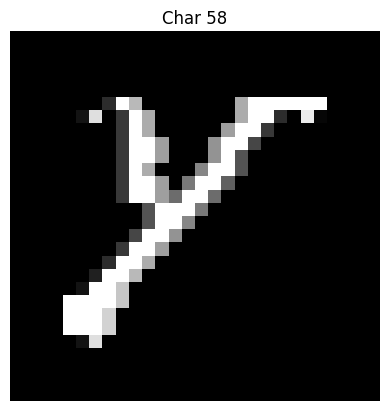

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 12 → Letra: 7


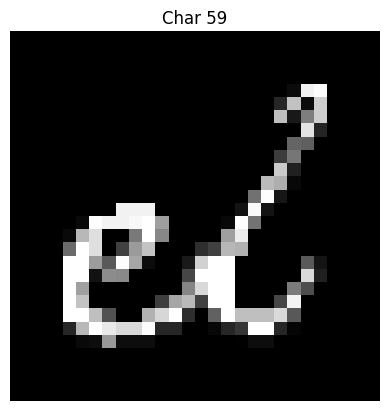

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 45 → Letra: A


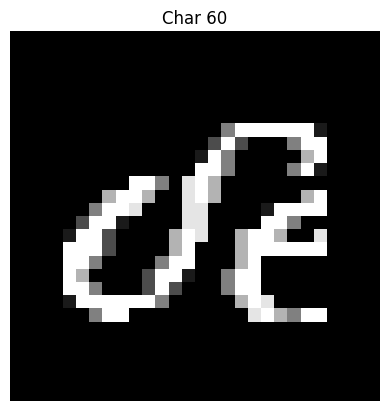

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
→ Cluster: 19 → Letra: h


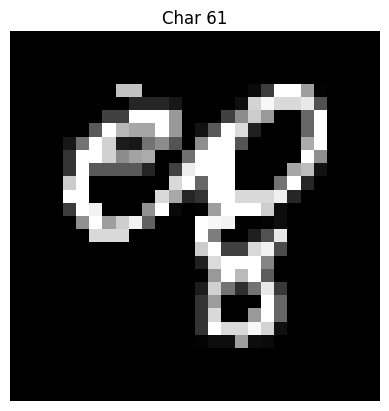

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
→ Cluster: 15 → Letra: O


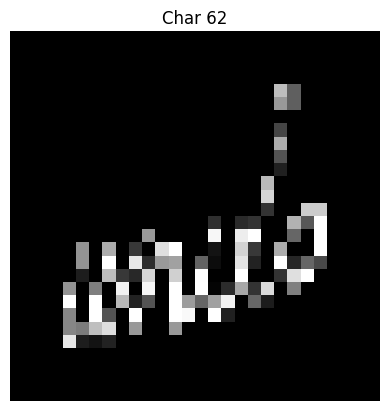

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 1 → Letra: v


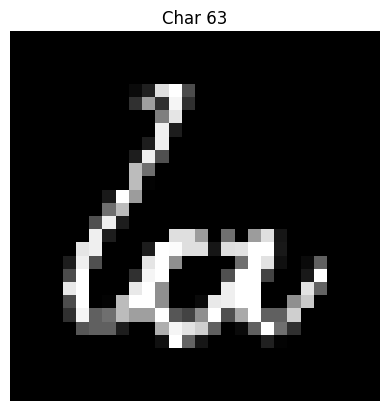

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 2 → Letra: d


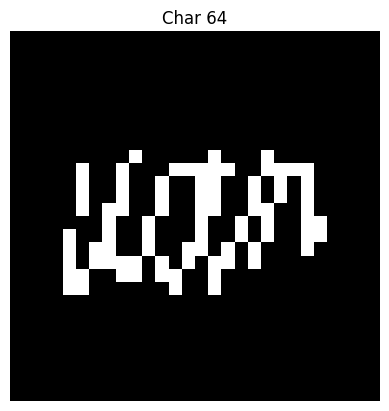

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 39 → Letra: A


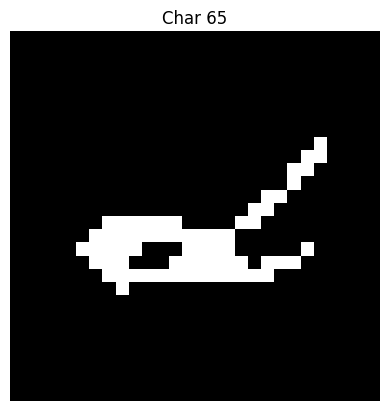

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 10 → Letra: g


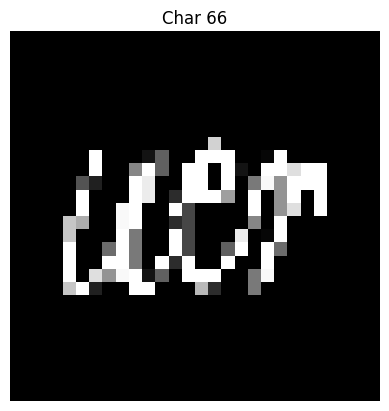

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 53 → Letra: 5


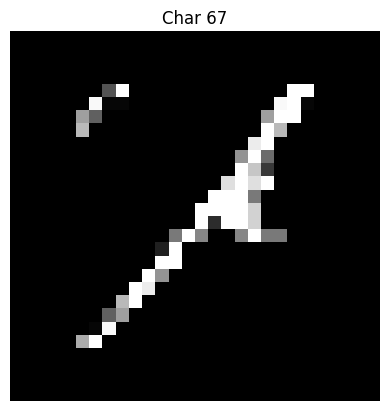

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
→ Cluster: 36 → Letra: T


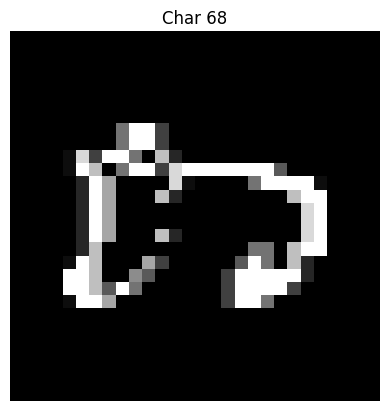

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
→ Cluster: 25 → Letra: g


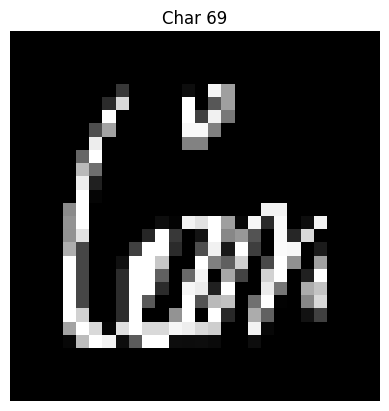

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
→ Cluster: 45 → Letra: A


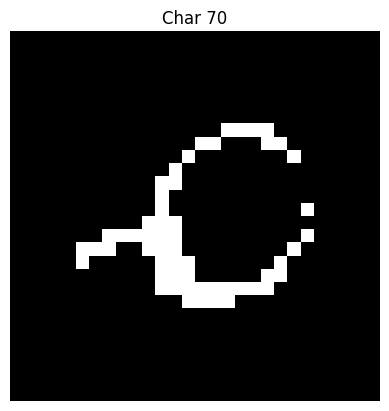

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
→ Cluster: 44 → Letra: a


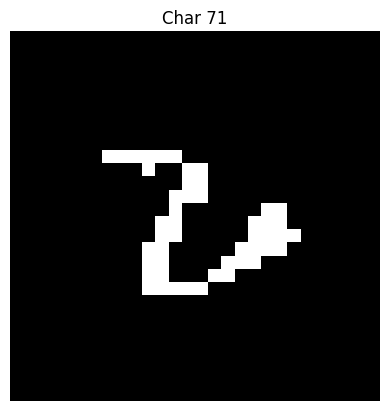

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
→ Cluster: 53 → Letra: 5


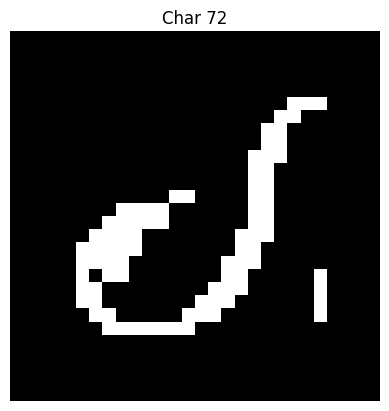

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
→ Cluster: 45 → Letra: A


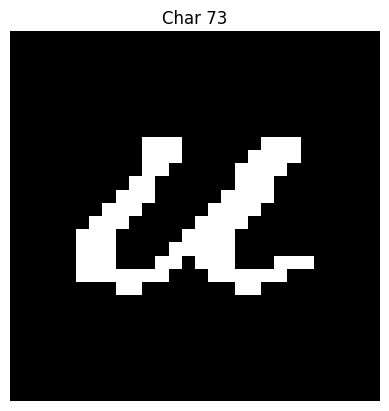

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 10 → Letra: g


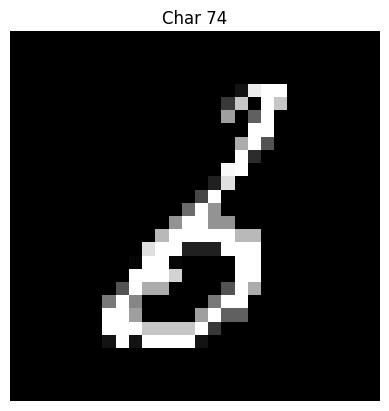

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 1 → Letra: v


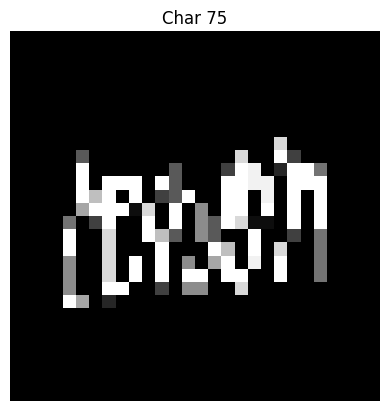

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
→ Cluster: 32 → Letra: H


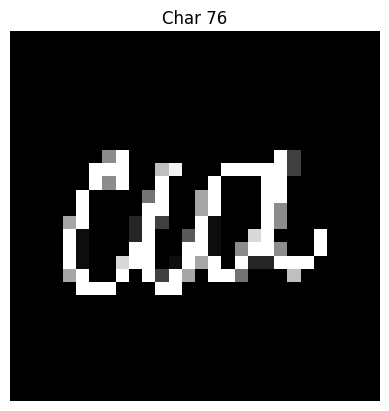

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
→ Cluster: 32 → Letra: H


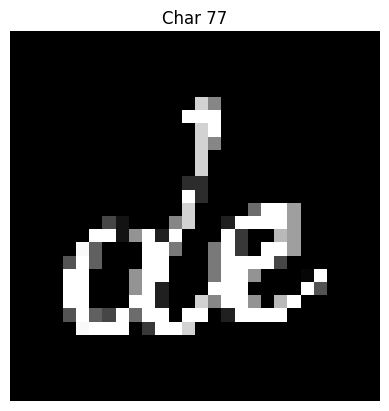

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
→ Cluster: 15 → Letra: O


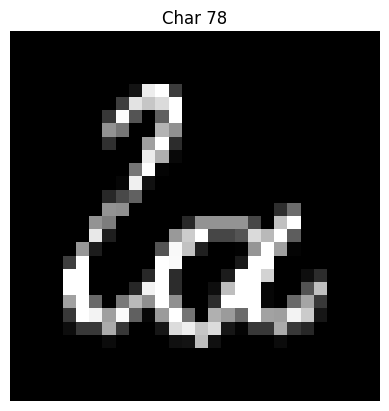

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
→ Cluster: 2 → Letra: d


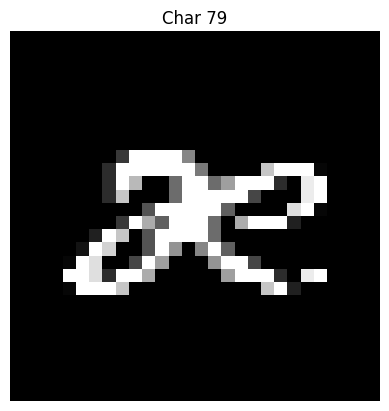

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
→ Cluster: 32 → Letra: H


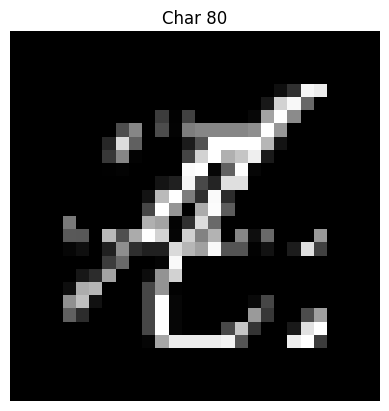

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
→ Cluster: 1 → Letra: v


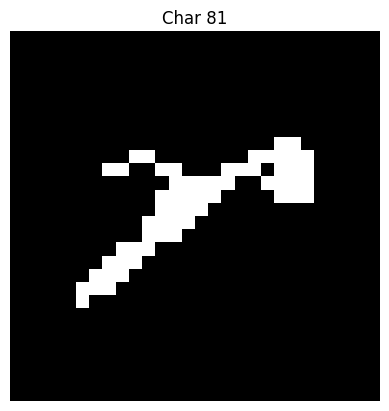

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 53 → Letra: 5


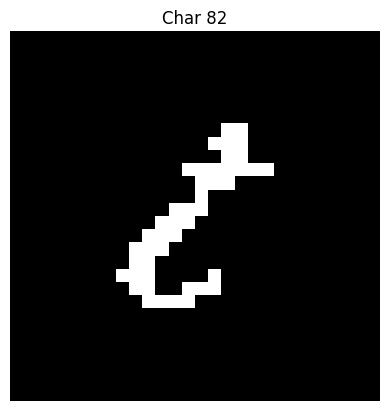

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
→ Cluster: 41 → Letra: f


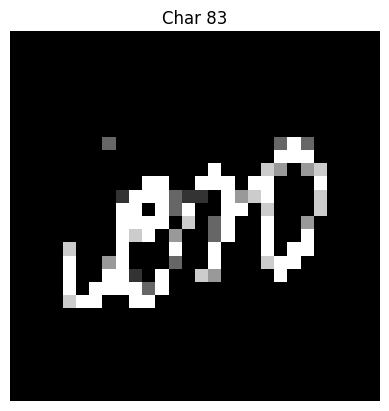

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
→ Cluster: 32 → Letra: H


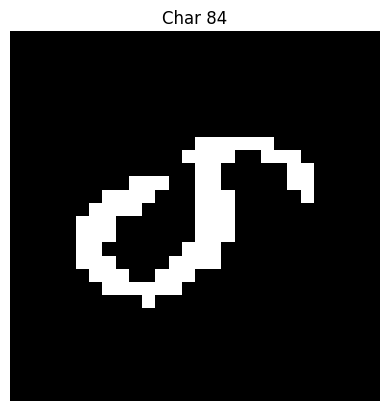

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
→ Cluster: 55 → Letra: g


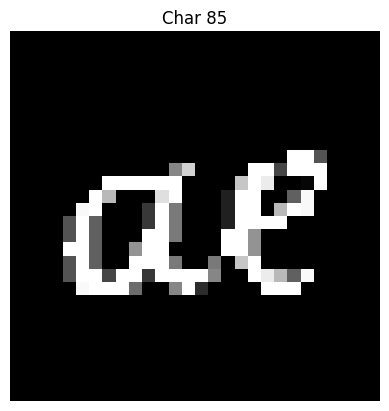

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 32 → Letra: H


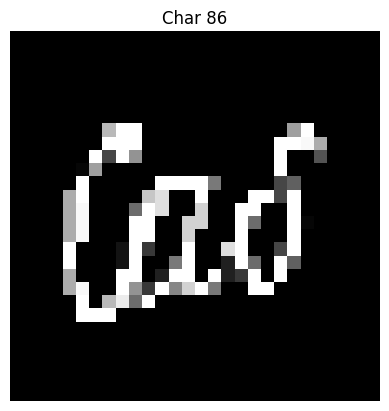

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 40 → Letra: m


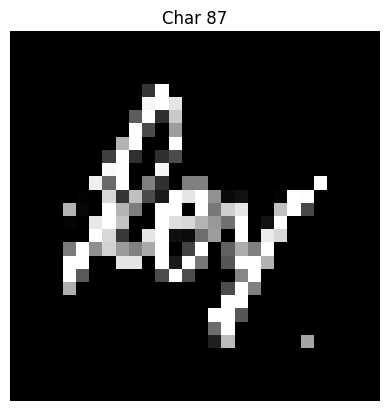

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
→ Cluster: 32 → Letra: H


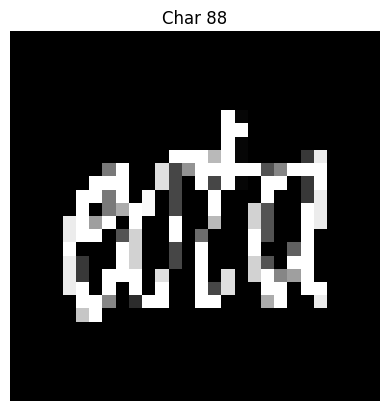

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
→ Cluster: 53 → Letra: 5


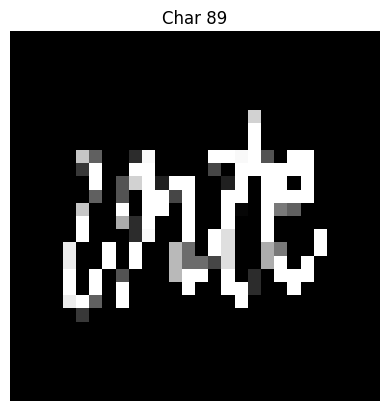

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
→ Cluster: 32 → Letra: H


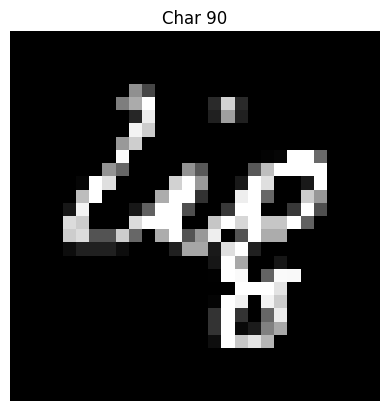

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
→ Cluster: 30 → Letra: E


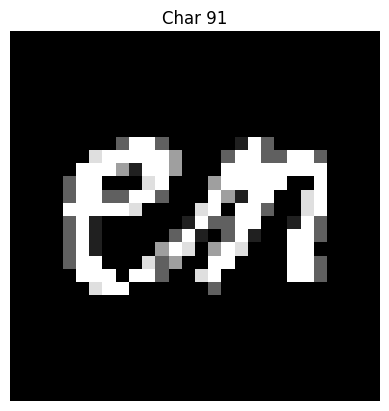

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
→ Cluster: 10 → Letra: g


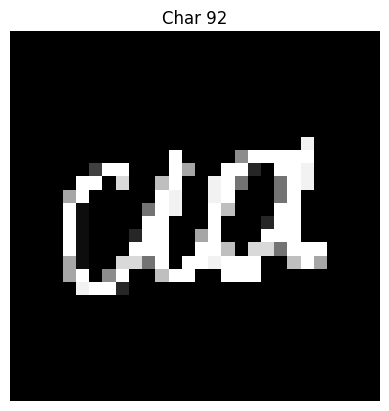

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
→ Cluster: 32 → Letra: H


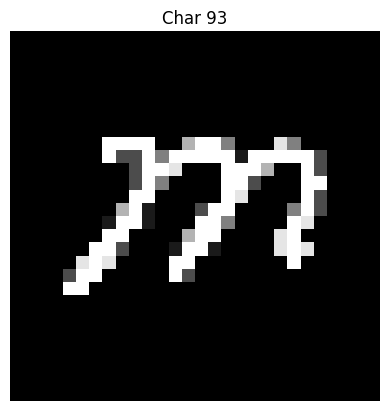

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
→ Cluster: 10 → Letra: g


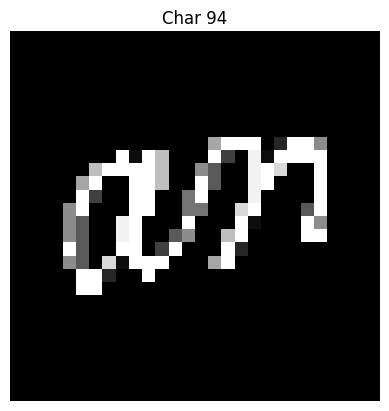

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
→ Cluster: 32 → Letra: H


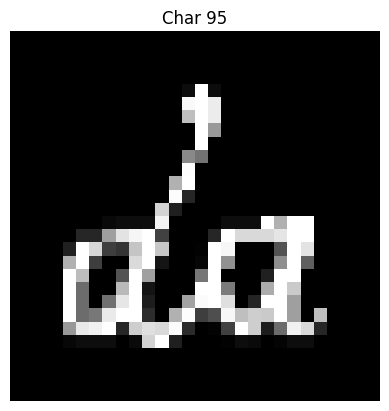

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
→ Cluster: 45 → Letra: A


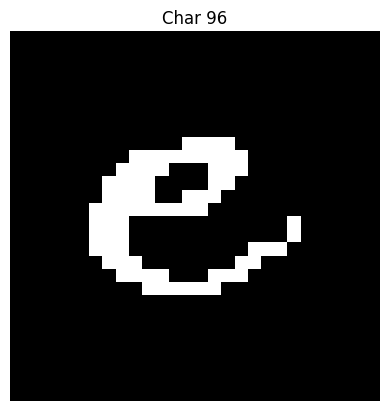

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
→ Cluster: 61 → Letra: V


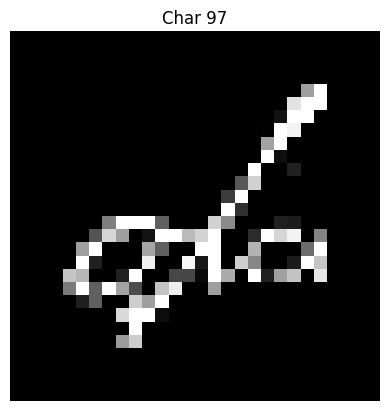

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 62 → Letra: h


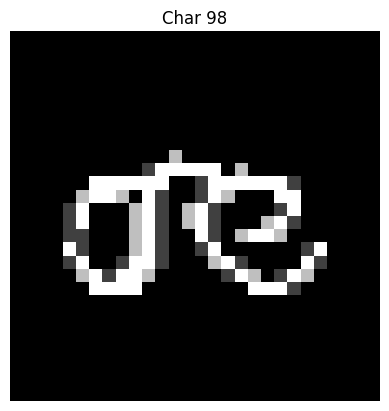

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
→ Cluster: 32 → Letra: H


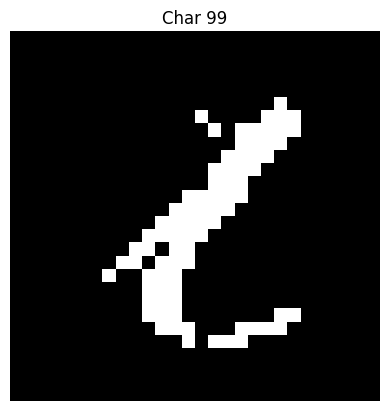

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 36 → Letra: T


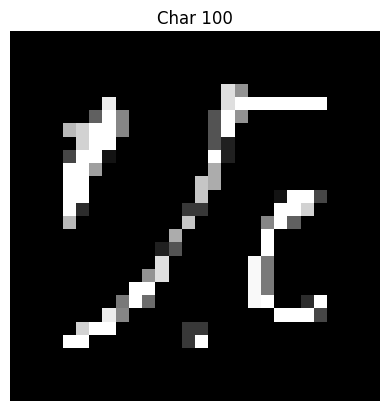

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
→ Cluster: 31 → Letra: d


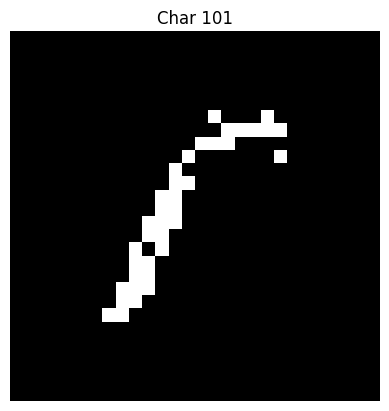

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 41 → Letra: f


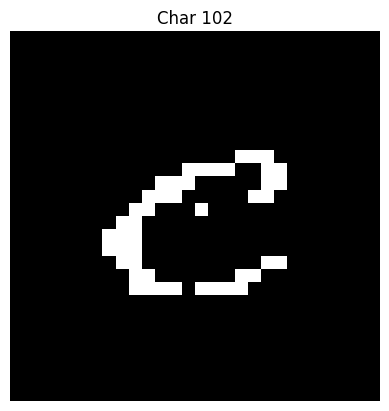

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
→ Cluster: 61 → Letra: V


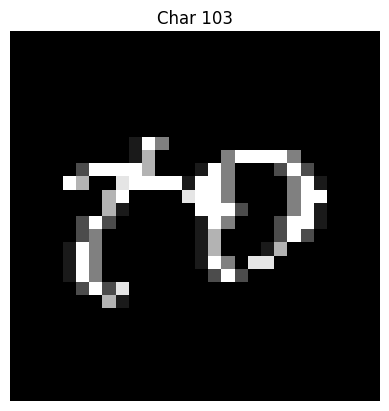

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
→ Cluster: 32 → Letra: H


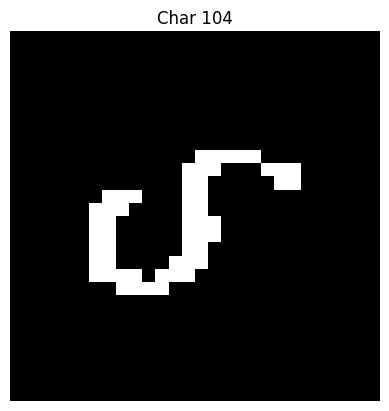

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
→ Cluster: 36 → Letra: T


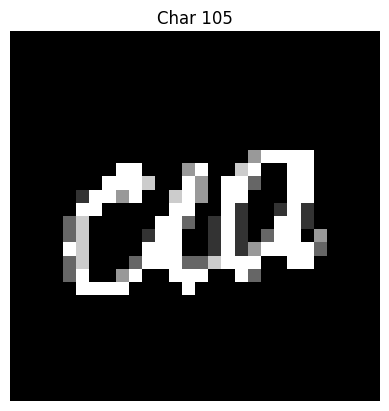

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
→ Cluster: 32 → Letra: H


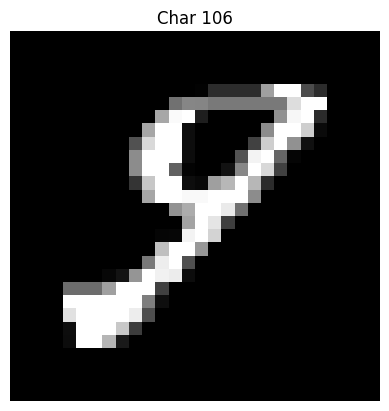

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
→ Cluster: 31 → Letra: d


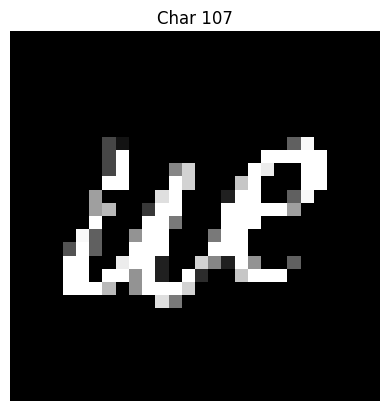

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
→ Cluster: 32 → Letra: H


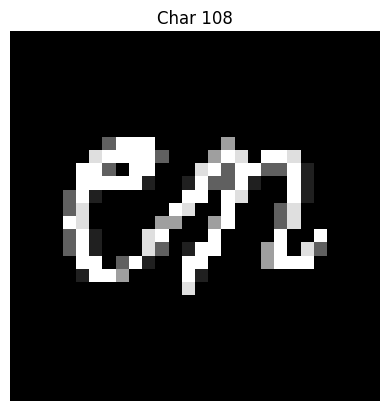

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 32 → Letra: H


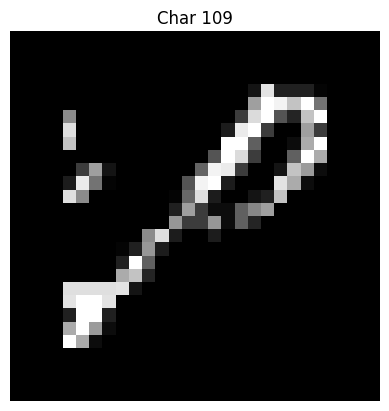

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 31 → Letra: d


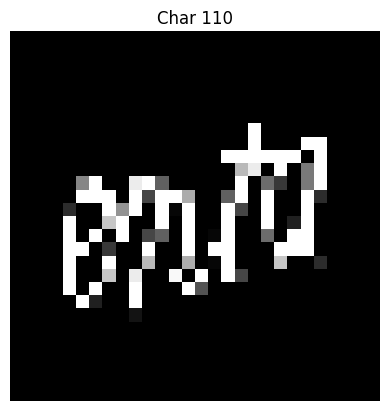

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
→ Cluster: 32 → Letra: H


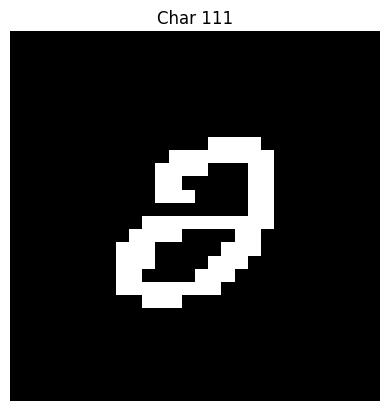

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
→ Cluster: 9 → Letra: G


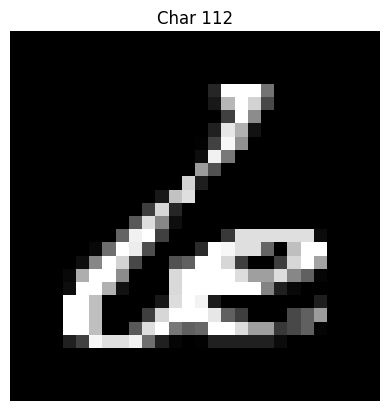

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 12 → Letra: 7


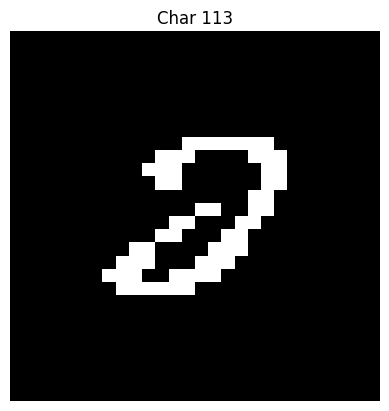

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
→ Cluster: 9 → Letra: G


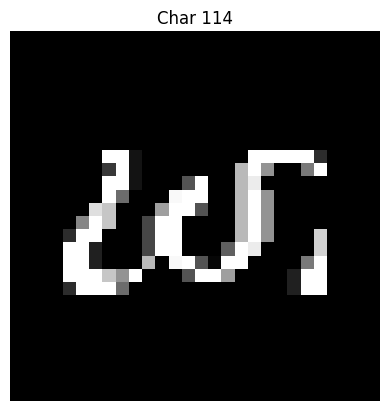

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
→ Cluster: 32 → Letra: H


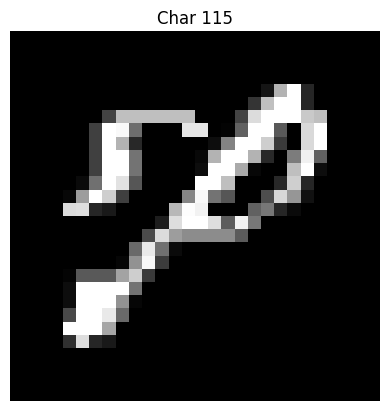

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
→ Cluster: 31 → Letra: d


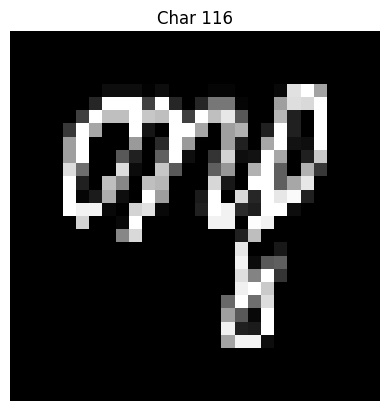

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
→ Cluster: 45 → Letra: A


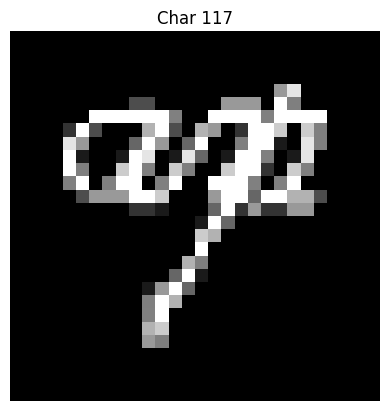

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
→ Cluster: 22 → Letra: Q


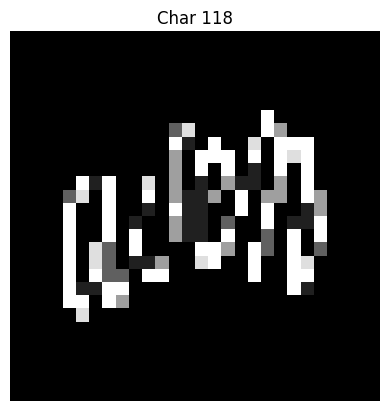

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
→ Cluster: 32 → Letra: H


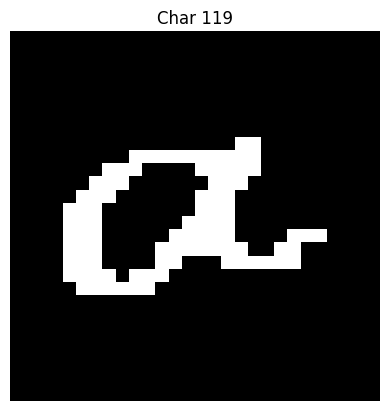

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
→ Cluster: 5 → Letra: L


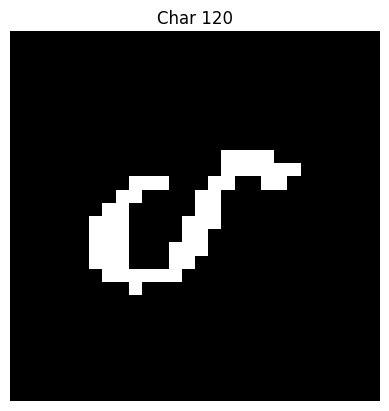

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
→ Cluster: 36 → Letra: T


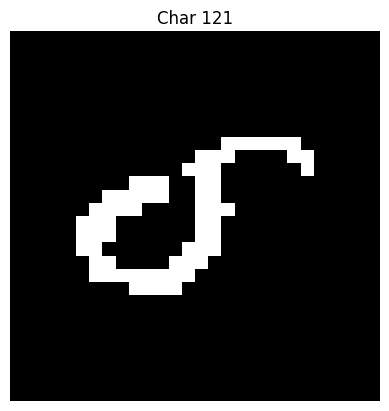

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 36 → Letra: T


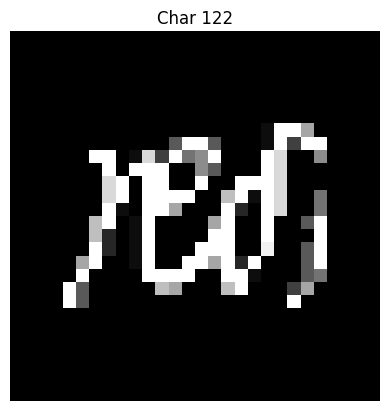

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
→ Cluster: 32 → Letra: H


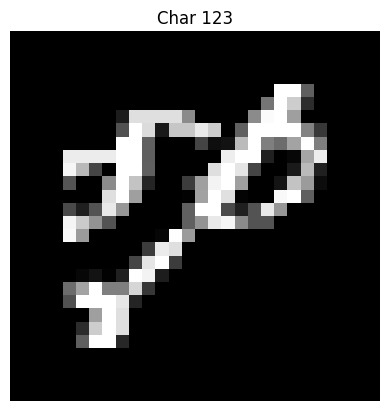

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
→ Cluster: 31 → Letra: d


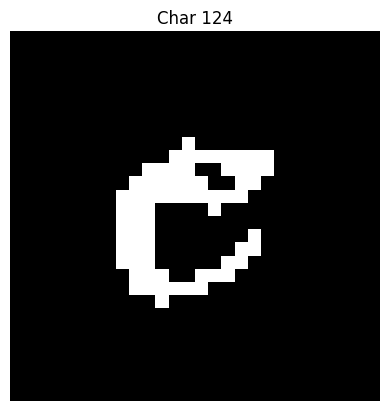

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
→ Cluster: 41 → Letra: f


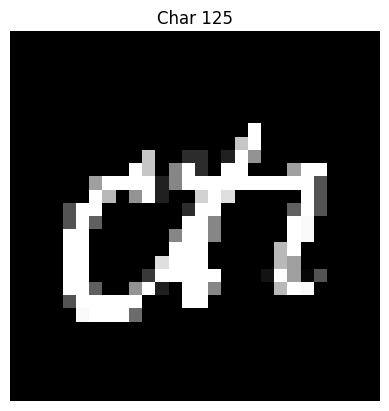

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
→ Cluster: 35 → Letra: s


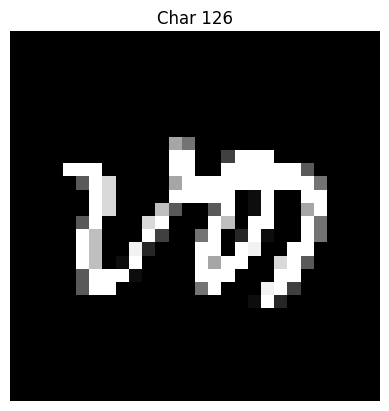

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 32 → Letra: H


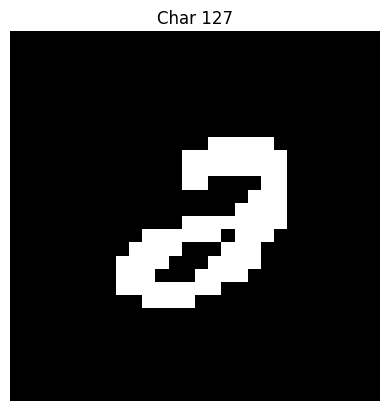

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
→ Cluster: 39 → Letra: A


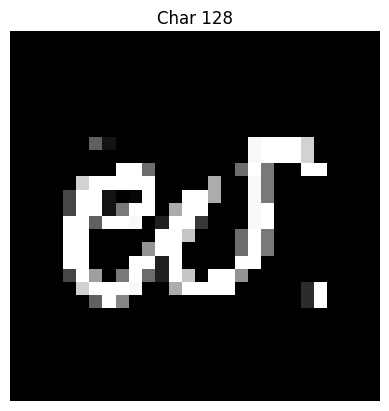

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
→ Cluster: 53 → Letra: 5


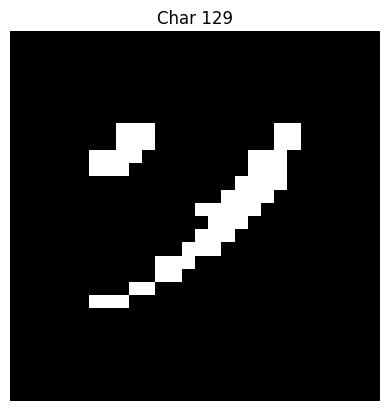

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 10 → Letra: g


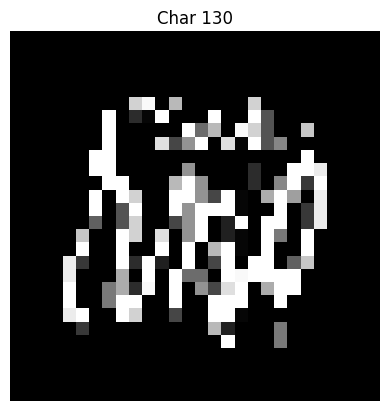

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
→ Cluster: 43 → Letra: H


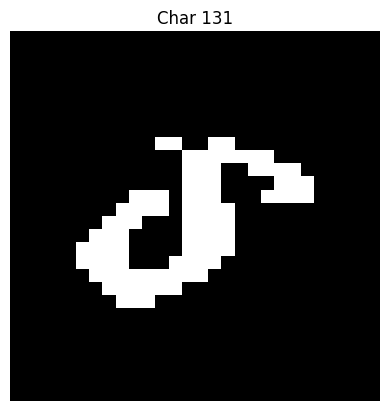

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
→ Cluster: 41 → Letra: f


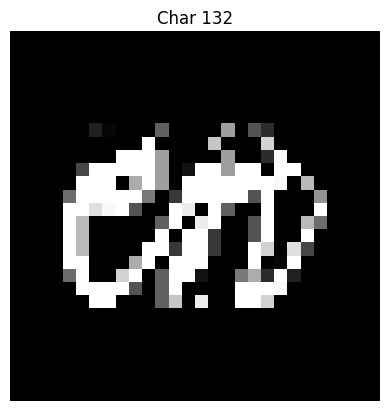

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
→ Cluster: 32 → Letra: H


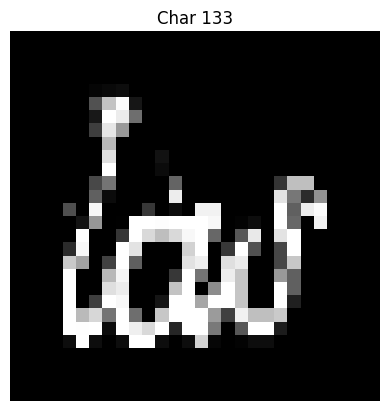

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
→ Cluster: 12 → Letra: 7


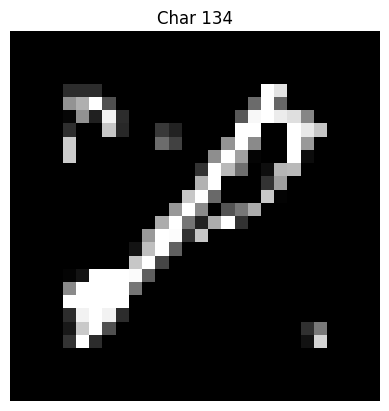

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 31 → Letra: d


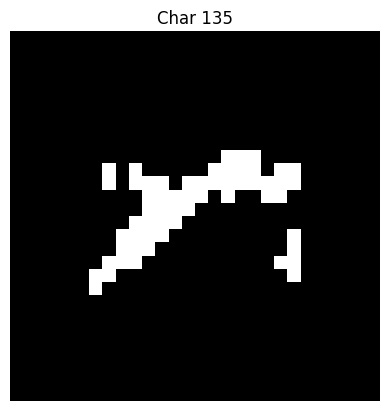

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
→ Cluster: 53 → Letra: 5


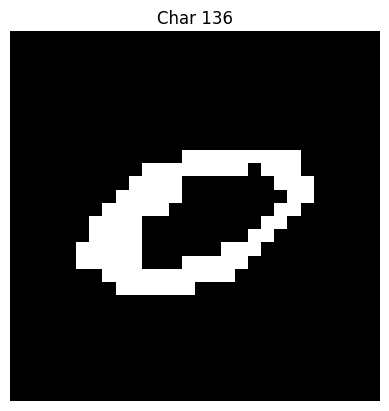

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
→ Cluster: 61 → Letra: V


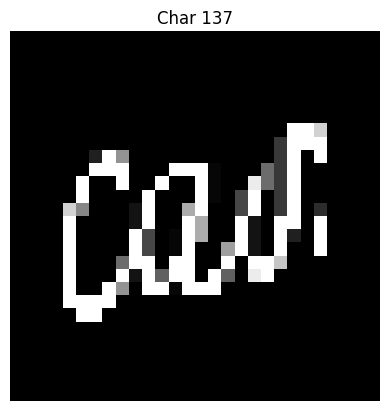

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
→ Cluster: 35 → Letra: s


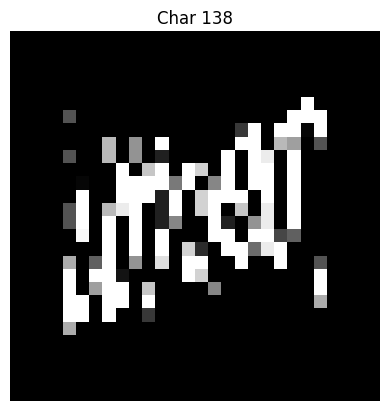

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
→ Cluster: 47 → Letra: e


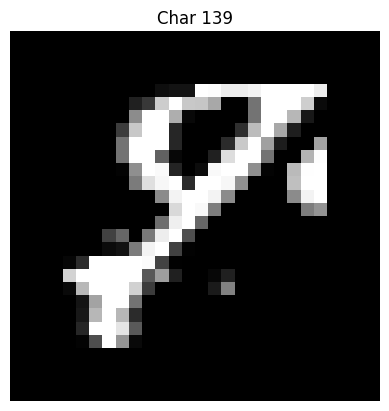

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
→ Cluster: 12 → Letra: 7


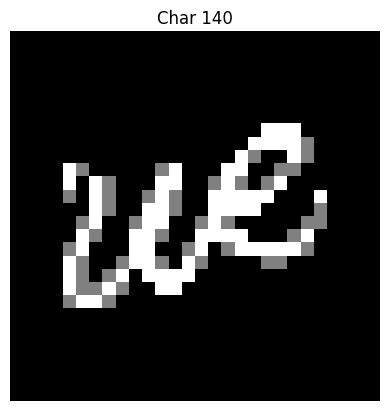

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
→ Cluster: 4 → Letra: I


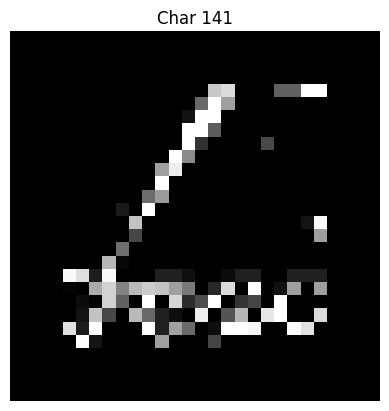

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
→ Cluster: 25 → Letra: g


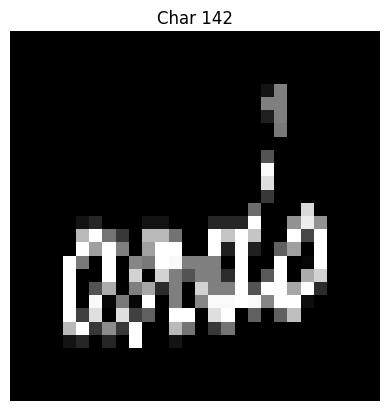

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 16 → Letra: P


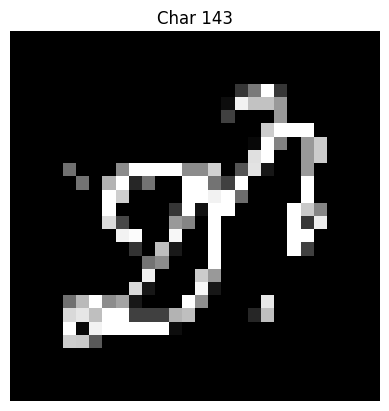

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
→ Cluster: 31 → Letra: d


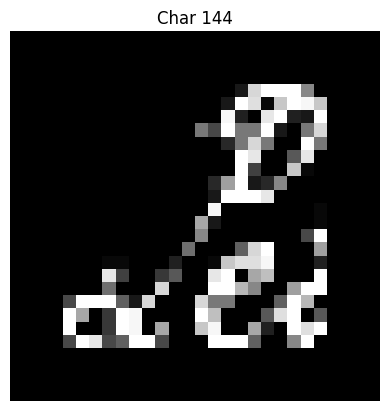

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
→ Cluster: 31 → Letra: d


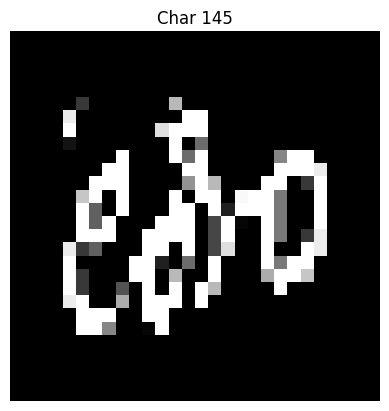

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
→ Cluster: 32 → Letra: H


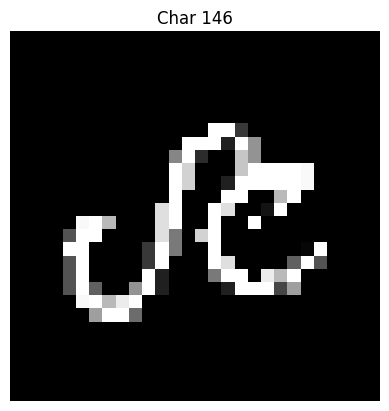

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
→ Cluster: 18 → Letra: r


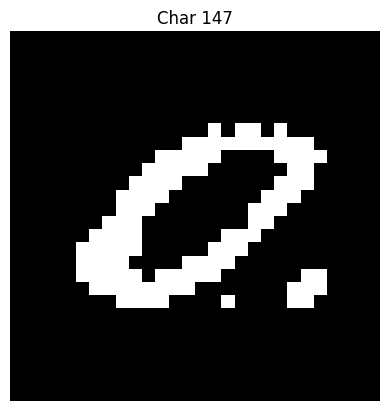

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
→ Cluster: 9 → Letra: G


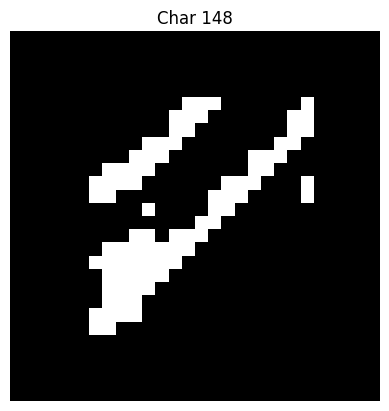

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
→ Cluster: 10 → Letra: g


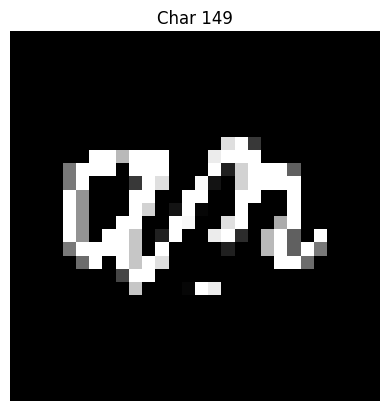

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
→ Cluster: 32 → Letra: H


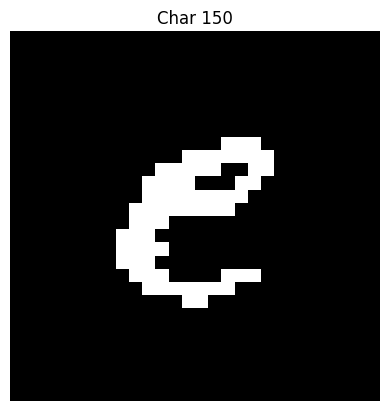

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
→ Cluster: 41 → Letra: f


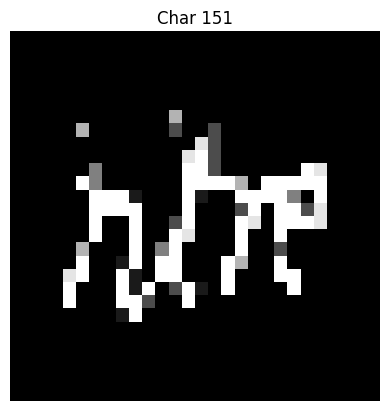

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
→ Cluster: 53 → Letra: 5


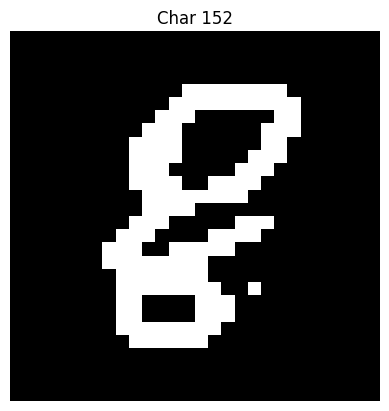

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
→ Cluster: 37 → Letra: O


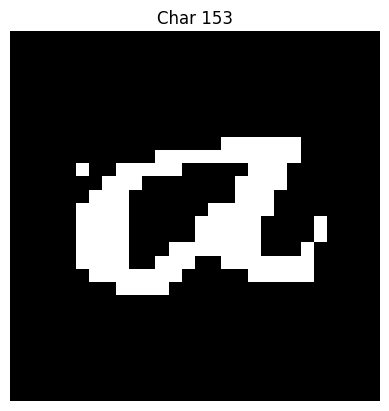

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
→ Cluster: 10 → Letra: g


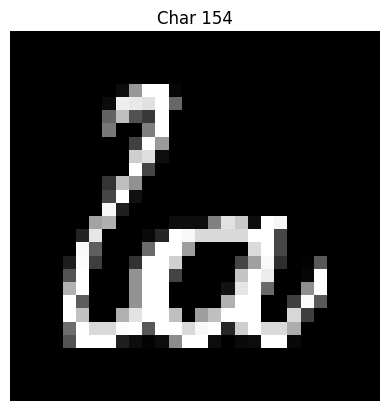

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
→ Cluster: 26 → Letra: G


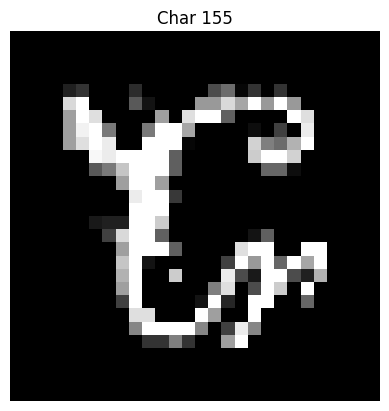

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
→ Cluster: 60 → Letra: H


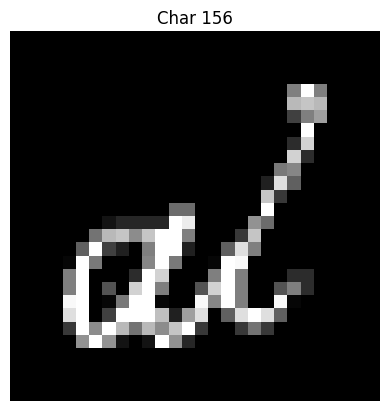

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
→ Cluster: 28 → Letra: W


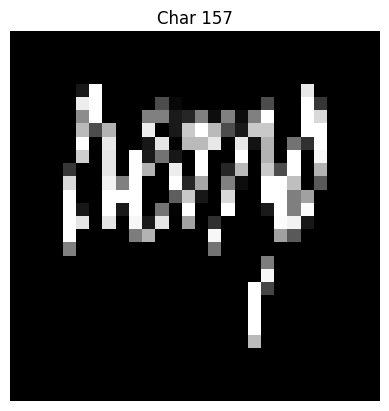

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
→ Cluster: 45 → Letra: A


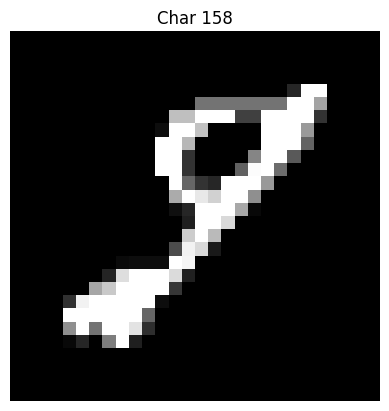

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
→ Cluster: 55 → Letra: g


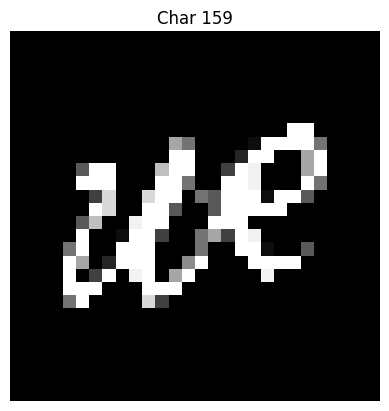

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
→ Cluster: 18 → Letra: r


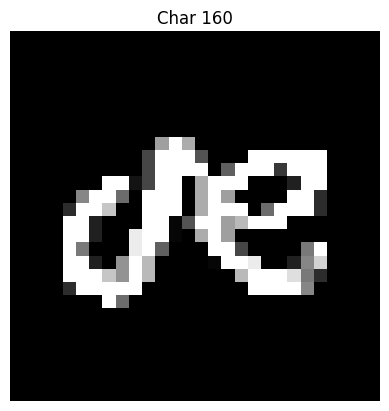

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
→ Cluster: 32 → Letra: H


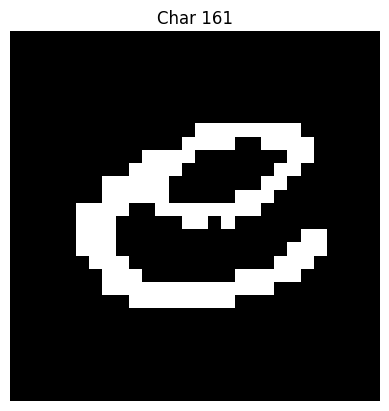

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
→ Cluster: 17 → Letra: s


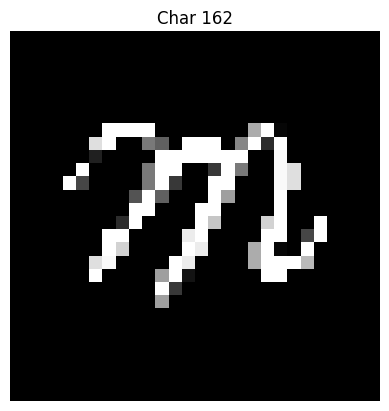

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
→ Cluster: 32 → Letra: H


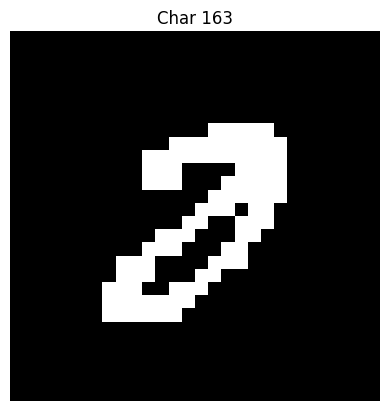

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
→ Cluster: 9 → Letra: G


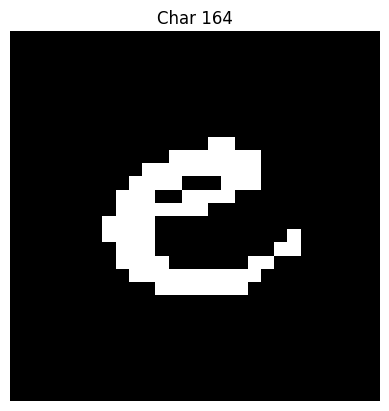

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
→ Cluster: 61 → Letra: V


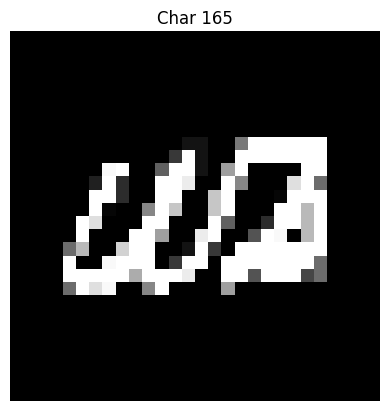

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
→ Cluster: 53 → Letra: 5


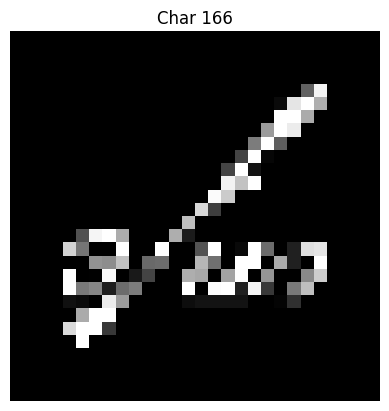

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
→ Cluster: 31 → Letra: d


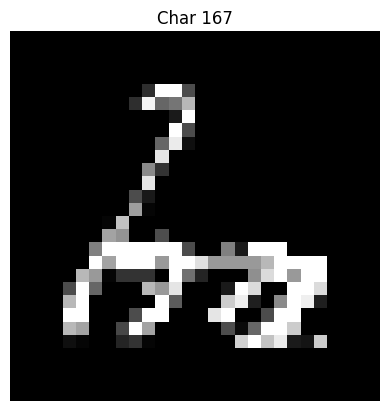

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
→ Cluster: 59 → Letra: t


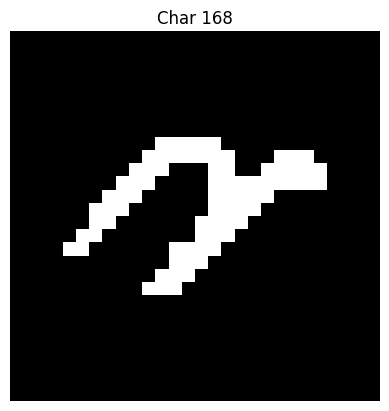

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
→ Cluster: 10 → Letra: g


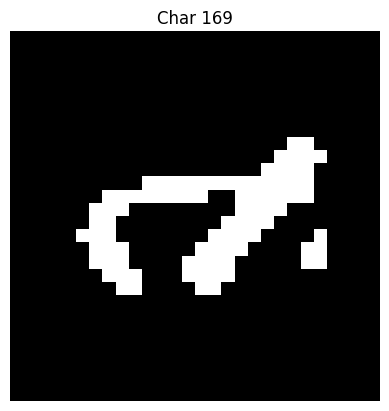

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
→ Cluster: 10 → Letra: g


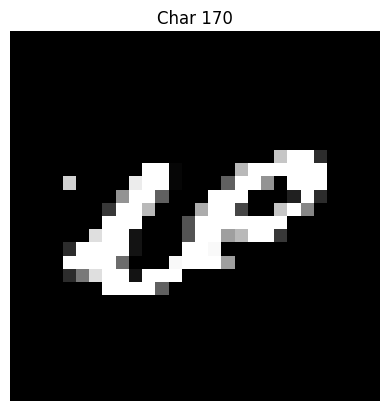

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 10 → Letra: g


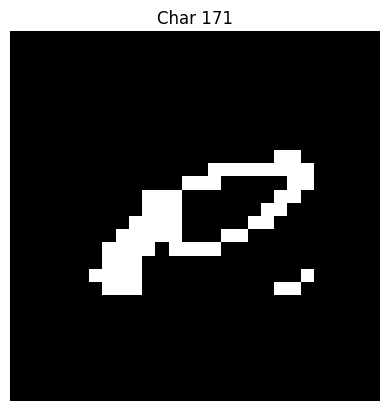

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
→ Cluster: 4 → Letra: I


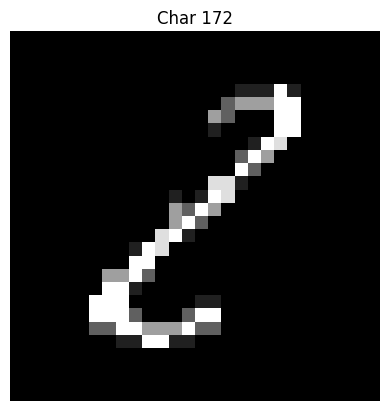

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
→ Cluster: 31 → Letra: d


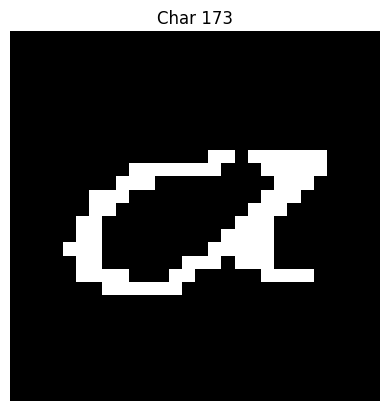

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 13 → Letra: C


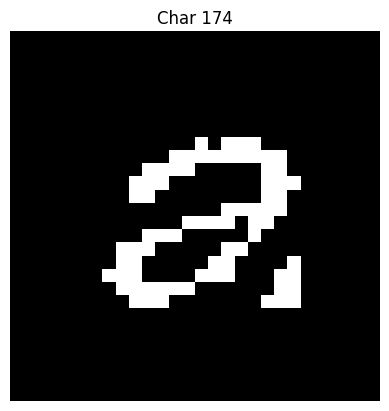

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 9 → Letra: G


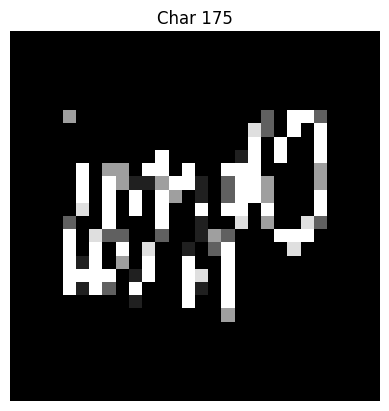

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
→ Cluster: 32 → Letra: H


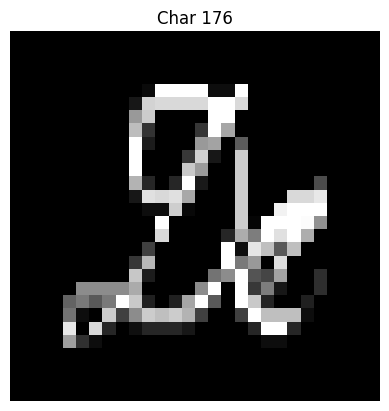

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 15 → Letra: O


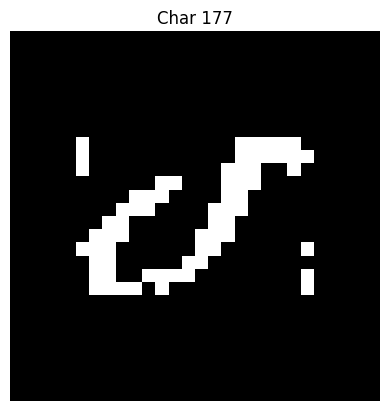

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
→ Cluster: 10 → Letra: g


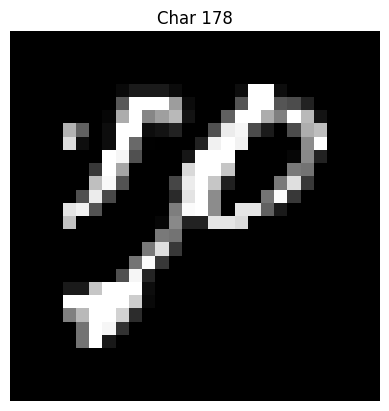

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
→ Cluster: 12 → Letra: 7


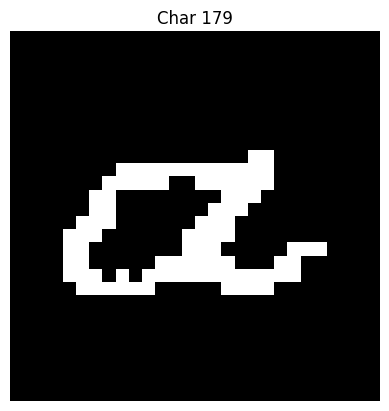

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
→ Cluster: 35 → Letra: s


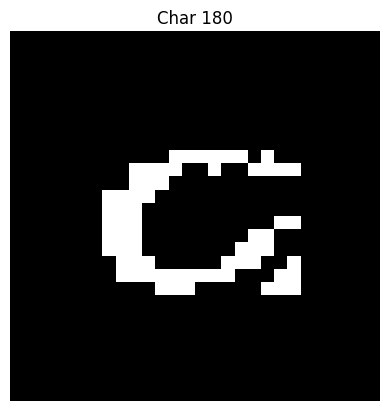

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
→ Cluster: 61 → Letra: V


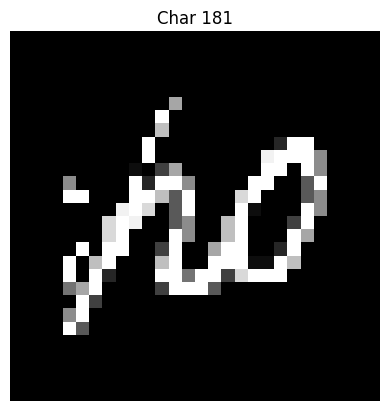

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
→ Cluster: 32 → Letra: H


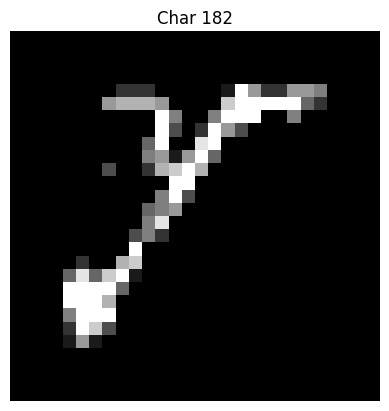

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
→ Cluster: 45 → Letra: A


In [57]:
debug_prediction_by_char(image_path)